In [ ]:
!sudo apt update
!sudo apt-get update
!pip install --upgrade --force-reinstall pandas
!pip install multiprocessing
!pip install cftime
!pip install cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
!pip install netCDF4

!sudo apt-get install texlive-latex-recommended
!sudo apt install texlive-latex-base texlive-latex-extra texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

import os
os.kill(os.getpid(), 9)

## Imports


In [1]:
import numpy as np
import networkx as nx
import pandas as pd
# import re
from datetime import datetime, timedelta
from tqdm.notebook import tqdm, trange
import gzip
import os
import pickle as pkl
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset
from matplotlib import rc
%matplotlib inline
import ftplib
from netCDF4 import Dataset
import h5py
import cftime
import sys


np.set_printoptions(linewidth=250)

font_dir = '/usr/local/lib/python' + str(sys.version_info[0]) + '.' + str(sys.version_info[1]) + '/dist-packages/matplotlib/mpl-data/fonts/ttf/'

## Set working directory

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

# Set this as the directory in which to save figures
base_dir = '/content/gdrive/My Drive/Climate Networks/'
os.chdir(base_dir)

fig_dir = base_dir + 'Figures/'
if not os.path.isdir(fig_dir):
  os.mkdir(fig_dir)

data_dir = base_dir + 'Data/'

Mounted at /content/gdrive


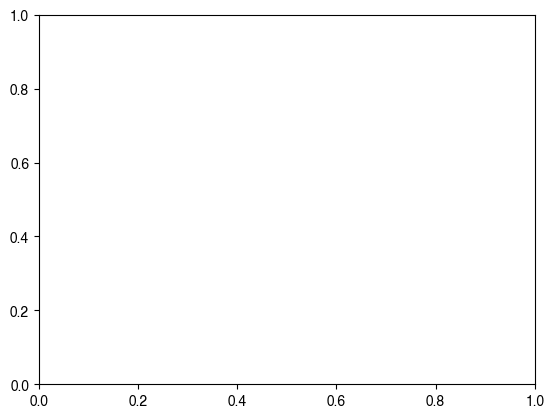

In [3]:
!cp Helvetica.ttf $font_dir

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
plt.xticks(fontname = 'Helvetica')
plt.yticks(fontname = 'Helvetica')
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{xfrac}')


plt.rcParams['savefig.bbox'] = 'tight'

import matplotlib.font_manager as fm
# fm.FontProperties(fname='/content/gdrive/MyDrive/Helvetica.ttf', size= 24)
fm.fontManager.addfont(font_dir + 'Helvetica.ttf')
# fm.fontManager.addfont(font_dir + 'helvetica.ttf')
# fm.fontManager.ttflist += fm.createFontList(['/content/gdrive/MyDrive/Helvetica.ttf'])
# mpl.rc('font', family='Helvetica')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

prop = fm.FontProperties(fname=font_dir+'Helvetica.ttf')
# prop = fm.FontProperties(fname=font_dir+'helvetica.ttf')
font = {'fontname':'Helvetica'}

## Project to icosahedral grid (and pull data from NOAA if requested)

In [4]:
# pp=int(input('grid parameter (3 for 642 and 4 for 2562 grids) = '))
pp = 5


recompute_icosahedral_data = False

if recompute_icosahedral_data:
  def get_adjacent_points(point_list,n_iter):
    adj_points = []
    for i in range(len(point_list)):
      v1 = point_list[i]
      for j in range(i,len(point_list)):
        v2 = point_list[j]
        x1,y1,z1 = v1[0],v1[1],v1[2]  ## first points
        x2,y2,z2 = v2[0],v2[1],v2[2]  ## second point

        d = np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)
        if 2/(2**n_iter)-0.05<=d and d<=2/(2**n_iter)+0.05:
          adj_points.append([v1,v2])
    return adj_points

  def get_midpoint(orig_list,adj_point_list):
    final_list = list(orig_list)
    for i in range(len(adj_point_list)):
      v1 = adj_point_list[i][0]
      v2 = adj_point_list[i][1]
      x1,y1,z1 = v1[0],v1[1],v1[2]   ## first point
      x2,y2,z2 = v2[0],v2[1],v2[2]   ## second point
      mid_x,mid_y, mid_z = (x1+x2)/2,(y1+y2)/2,(z1+z2)/2   ## midpoints of two points
      midpoint = (mid_x,mid_y,mid_z)
      final_list.append(midpoint)     ## It will append the midpoints to the other 12 grid points
    return final_list

  def triangulate_icosahedron(icosahedron,n_iterations):
    for i in range(n_iterations):
      adj = get_adjacent_points(icosahedron,i)
      icosahedron = get_midpoint(icosahedron,adj)
    return icosahedron

  def project(final,radius):
    sphere_triangulation = []
    for point in final:
      x,y,z = point[0],point[1],point[2]
      mag = np.sqrt(x**2+y**2+z**2)              ## magnitude of a point
      sphere_point = (radius*x/mag,radius*y/mag,radius*z/mag)      ## projection of that point into sphere
      sphere_triangulation.append(sphere_point)
    return sphere_triangulation

  def convert(points,r):
    latlonlist = []
    for pnt in points:
      x,y,z = pnt[0],pnt[1],pnt[2]
      x,y,z = round(x,6),round(y,6),round(z,6)   ## round to 6 decimal digits
      lat,lon = 0,0
      if x == 0:
        if y >= 0:
          lon = 90.0
        else:
          lon = 270.0
      else:
        lon = np.degrees(np.arctan2(y,x))      ## lon from (0 to 360) as usual cartesian coordinate
        if lon < 0:
          lon = 360+lon
      lat = 90-np.degrees(np.arccos(z/r))        ## if z>0 then lat is positive otherwise negative
      latlonlist.append((lat,lon))
    return latlonlist

  def findgridpoints(icospoint,lats,lons):
    '''
    Finds the four grid points that surround
    each point on the icosahedral grid
    '''
    icoslat, icoslon = icospoint

    done=False
    i=0
    gridlat1,gridlon1=0,0
    gridlat2,gridlon2=0,0
    #Iterate through the latitudes and longitudes of the regular latitude-longitude
    #grid, when the latitude/longitude of the icosahedral grid point is in between
    #two of the values in the regular grid, store them
    #
    #The latitude iterations will always find the surrounding latitudes, the
    #longitude iterations will halt at 357.5 degrees, and store the longitudes
    #357.5 degrees and 0 degrees.
    while not done:
      if lats[i]>=icoslat and lats[i+1]<=icoslat:
        done=True
        gridlat1=lats[i]
        gridlat2=lats[i+1]
      else:
        i+=1
    i1 = i
    i2 = i+1

    done=False
    j=0
    while not done:
      if lons[j]<=icoslon and lons[j+1]>=icoslon:
        done=True
        gridlon1=lons[j]
        gridlon2=lons[j+1]
      else:
        j += 1
        if j == len(lons)-1:
          done=True
          gridlon1=lons[-1]
          gridlon2=360
    if j == 143:
      j1 = -1
      j2 = 0
    else:
      j1 = j
      j2 = j+1

    # lats = np.array(lats) - icoslat
    # for i in range(len(lats)):
    #   if lats[i] <= 0:
    #     gridlat1, gridlat2 = lats[i-1]+icoslat, lats[i]+icoslat
    #     break
    # i1 = i-1
    # i2 = i

    # if icoslon >= lons[-1]:
    #   gridlon1, gridlon2 = lons[-1], 360
    #   j1 = -1
    #   j2 = 0
    # else:
    #   lons = np.array(lons) - icoslon
    #   for j in range(len(lons)):
    #     if lons[j] >= 0:
    #       gridlon1, gridlon2 = lons[j-1]+icoslon, lons[j]+icoslon
    #       break
    #   j1 = j-1
    #   j2 = j

    return gridlat1, gridlat2, gridlon1, gridlon2, i1, i2, j1, j2

  def projectdata(icoslatslons,nctimeseries,lats,lons):
    icosahedral_data = np.zeros((len(icoslatslons),len(nctimeseries[0][0])))
    for i in trange(len(icoslatslons)):
      x, y = icoslatslons[i]
      x1, x2, y1, y2, x1id, x2id, y1id, y2id = findgridpoints((x,y),lats,lons)
      # T11 = nctimeseries[x1id][y1id]
      # T21 = nctimeseries[x2id][y1id]
      # T12 = nctimeseries[x1id][y2id]
      # T22 = nctimeseries[x2id][y2id]
      # pointTS = []
      for t in range(len(nctimeseries[x1id][y1id])):
        xy1 = (x2-x)/(-2.5)*nctimeseries[x1id][y1id][t] + (x-x1)/(-2.5)*nctimeseries[x2id][y1id][t]
        xy2 = (x2-x)/(-2.5)*nctimeseries[x1id][y2id][t] + (x-x1)/(-2.5)*nctimeseries[x2id][y2id][t]
        temp = (y2-y)*xy1/(2.5) + (y-y1)*xy2/(2.5)
        icosahedral_data[i,t] = temp
        # pointTS.append(temp)
      # icosahedral_data.append(pointTS)
    return icosahedral_data

  def daily_anomalies(data):
    n=np.shape(data)[1] #number of nodes
    k=np.shape(data)[0]
    n1=n#np.shape(data)[1]-(365*14)
    for j in trange(k):
      for i in range(365):
        indices=np.arange(i,n,365)
        indices1=np.arange(i,n1,365)
        data[j,indices]=(data[j,indices]-np.mean(data[j,indices1]))/(np.std(data[j,indices1]))
    return data






  raw_downloads_dir = data_dir + 'Raw Reanalysis Downloads/'
  if not os.path.isdir(raw_downloads_dir):
    os.mkdir(raw_downloads_dir)

  repull_data = False

  if repull_data:
    ftp = ftplib.FTP("ftp2.psl.noaa.gov")
    ftp.login("anonymous", "pass")

    ftp.cwd("/Datasets/ncep.reanalysis.dailyavgs/surface/")

    data = []

    ftp.dir(data.append)

    total = 0
    for line in data:
      if 'air.' in line:
        total += 1

    lst = tqdm(data, total=total)
    for line in lst:
        if 'air.' in line:
          filename = line.split(' ')[-1]
          lst.set_description('Pulling data: '+filename.split('.')[2])
          # print(filename)
          with open(raw_downloads_dir+filename, 'wb') as f:
              ftp.retrbinary("RETR " + filename, f.write)
    lst.close()

    ftp.quit()

    dates = []
    for filename in os.listdir(raw_downloads_dir):
      dates.append(filename.split('.')[2])

    lst = tqdm(dates)
    for date in lst:
      lst.set_description('Compiling Data: '+date)
      if date == dates[0]:
        ncfile = raw_downloads_dir + 'air.sig995.'+str(date)+'.nc'
        fh = Dataset(ncfile,mode='r')
        lons = fh.variables['lon'][:]
        lats = fh.variables['lat'][:]
        air = np.array(fh.variables['air'][:])
        time = np.array(fh.variables['time'][:])
        time_unit = fh.variables['time'].units
        fh.close()
      else:
        ncfile = raw_downloads_dir + 'air.sig995.'+str(date)+'.nc'
        fh = Dataset(ncfile,mode='r')
        air = np.concatenate((air,np.array(fh.variables['air'][:])),axis=0)
        time = np.concatenate((time,np.array(fh.variables['time'][:])),axis=0)
        fh.close()

    # time = [cftime.num2date(t,time_unit,only_use_python_datetimes=True).strftime('%m/%d/%Y') for t in time]
    time_copy = [None]*len(time)
    for i in range(len(time)):
      try:
        a = cftime.num2date(time[i],time_unit,only_use_python_datetimes=True).strftime('%m/%d/%Y')
      except:
        a = (datetime.strptime(cftime.num2date(time[i-1],time_unit,only_use_python_datetimes=True).strftime('%m/%d/%Y'),'%m/%d/%Y')  + timedelta(days=1)).strftime('%m/%d/%Y')
      time_copy[i] = a
    time = time_copy


    air = np.transpose(air, (1, 2, 0))
    print(air.shape)
    print(np.shape(time))

    with gzip.open(data_dir+'surface_air_temperature.data','wb') as file:
      pkl.dump(np.array(lats),file)
      pkl.dump(np.array(lons),file)
      pkl.dump(np.array(air),file)

    time.sort(key = lambda k: datetime.strptime(k, '%m/%d/%Y'))

    with gzip.open(data_dir+'time.data','wb') as file:
      pkl.dump(time,file)
  else:
    with gzip.open(data_dir+'surface_air_temperature.data','rb') as file:
      lats = pkl.load(file)
      lons = pkl.load(file)
      air = pkl.load(file)

    with gzip.open(data_dir+'time.data','rb') as file:
      time = pkl.load(file)

  p=(1+np.sqrt(5))/2                                       #golden ratio
  icos=[(1,p,0),(-1,p,0),(1,-p,0),(-1,-p,0),
        (0,1,p),(0,-1,p),(0,1,-p),(0,-1,-p),
        (p,0,1),(p,0,-1),(-p,0,1),(-p,0,-1)]     # 12 icosahedron vertices
  rad=np.sqrt(1+p**2)         #radius of sphere that circumscribes the icosahedron

  latlon = sorted(convert(project(triangulate_icosahedron(icos,pp),rad),rad),
                  key=lambda k:[k[1],k[0]])
  icosahedral_data = np.array(projectdata(latlon,air,lats,lons))
  icosahedral_data = daily_anomalies(icosahedral_data)

  with gzip.open(data_dir + 'icosahedral_data.data', 'wb') as file:
    pkl.dump(icosahedral_data, file)
else:
  with gzip.open(data_dir + 'icosahedral_data.data', 'rb') as file:
    icosahedral_data = pkl.load(file)

  with gzip.open(data_dir+'time.data','rb') as file:
    time = pkl.load(file)

## Calculate correlations (pairs)

In [5]:
from scipy.stats import pearsonr
from scipy.special import betainc

def corrcoef(matrix):
    r = np.corrcoef(matrix)
    rf = r[np.triu_indices(r.shape[0], 1)]
    df = matrix.shape[1] - 2
    ts = rf * rf * (df / (1 - rf * rf))
    pf = betainc(0.5 * df, 0.5, df / (df + ts))
    p = np.zeros(shape=r.shape)
    p[np.triu_indices(p.shape[0], 1)] = pf
    p[np.tril_indices(p.shape[0], -1)] = p.T[np.tril_indices(p.shape[0], -1)]
    p[np.diag_indices(p.shape[0])] = np.ones(p.shape[0])
    return r, p

In [6]:
def save_data(data_lst, j, corr_dir):
  with gzip.open(corr_dir + str(j) + '.data', 'wb') as file:
    for data in data_lst:
      pkl.dump(data.astype(float), file)

def make_corr_mat(j, data, corr_dir, offset, months,
                  save_pval=False, multi=True):
  corr_mat, pvals = corrcoef(data)
  corr_mat = np.abs(corr_mat)

  # corr_mat = np.abs(np.corrcoef(data))

  if multi:
    try:
      save_data([corr_mat, pvals] if save_pval else [corr_mat], j, corr_dir)
    except:
      print('Could not save matrix: '+str(j))

    return j
  else:
    return corr_mat

In [7]:
!pip install multiprocessing

  Using cached multiprocessing-2.6.2.1.tar.gz (108 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [8]:
# months=int(input('window of one netwok in terms of months='))
# offset=int(input('offset of networks in days='))
# months = 12
# offset = 30
months = 300
offset = 365.25

save_pval = True

# total_networks = int((np.shape(icosahedral_data)[1]-int(months*365/12))/offset)+1
total_networks = round((np.shape(icosahedral_data)[1]-(months*365.25/12))/offset)+1

# Save time intervals
date_intervals = []
year_intervals = []
for i in range(total_networks):
  date_start = time[round(i*offset)]
  date_end = time[round((months*365.25/12)+(offset*i))-1]
  date_intervals.append([date_start, date_end])

  dates_start = [datetime.strptime('01/01/'+date_start.split('/')[-1], '%m/%d/%Y'),
                 datetime.strptime('01/01/'+str(int(date_start.split('/')[-1])-1), '%m/%d/%Y'),
                 datetime.strptime('01/01/'+str(int(date_start.split('/')[-1])+1), '%m/%d/%Y')]
  ind_start = np.argmin(np.abs([date.timestamp() - datetime.strptime(date_start, '%m/%d/%Y').timestamp() for date in dates_start]))
  year_start = dates_start[ind_start].strftime('%Y')

  dates_end = [datetime.strptime('01/01/'+date_end.split('/')[-1], '%m/%d/%Y'),
               datetime.strptime('01/01/'+str(int(date_end.split('/')[-1])-1), '%m/%d/%Y'),
               datetime.strptime('01/01/'+str(int(date_end.split('/')[-1])+1), '%m/%d/%Y')]
  ind_end = np.argmin(np.abs([date.timestamp() - datetime.strptime(date_end, '%m/%d/%Y').timestamp() for date in dates_end]))
  year_end = dates_end[ind_end].strftime('%Y')
  year_intervals.append([year_start, year_end])

existing_iters = []
corr_dir = data_dir + 'corr_mat-months='+str(months)+',offset='+str(offset)+'/' # or something like this
if not os.path.isdir(corr_dir):
  os.mkdir(corr_dir)
else:
  for filename in sorted(os.listdir(corr_dir), key = lambda k: int(k.replace('.data', ''))):
    if os.path.getsize(corr_dir + filename) > 1e6:
      existing_iters += [int(filename.replace('.data',''))]

# print(existing_iters)

parallel = True

if not parallel:
  for j in trange(total_networks):
    if j not in existing_iters:
      corr_list = make_corr_mat(j, icosahedral_data[:,round(j*offset):round((months*365.25/12)+(offset*j))],
                                corr_dir, offset, months, multi=False)
      # data = icosahedral_data[:,round(j*offset):round((months*365.25/12)+(offset*j))]
      # print(len(corr_list)/(len(data)*(len(data)-1)/2), len(np.where(corr_list[:,1] > 0)[0])/(len(data)*(len(data)-1)/2), corr_list[-1])
else:
  import multiprocessing as mp

  def handle_error(error):
      print(error)

  n_tasks = 4
  pool = mp.Pool(n_tasks)

  jobs = [pool.apply_async(make_corr_mat,
                          args=[j, icosahedral_data[:,round(j*offset):round((months*365.25/12)+(offset*j))],
                                corr_dir, offset, months, save_pval, True],
                          error_callback=handle_error) for j in range(total_networks) if j not in existing_iters]
  pool.close()

  result_lst = []
  lst = tqdm(jobs)
  for job in lst:
      j = job.get()
      print(j)
      result_lst.append(j)
      try:
        lst.set_description(str(j))
      except:
        pass

  pool.join()

0it [00:00, ?it/s]

In [9]:
import scipy as sp

In [10]:
num_nodes = len(icosahedral_data)

In [13]:
corrs = np.zeros((int(num_nodes*(num_nodes-1)/2),total_networks))
for i in trange(total_networks):
  with gzip.open(f'{corr_dir}/{i}.data', 'rb') as file:
    corr_mat = pkl.load(file)

  corrs[:,i] = corr_mat[np.triu_indices(len(corr_mat),1)]

  del corr_mat

  0%|          | 0/51 [00:00<?, ?it/s]

In [11]:
pval_dir = corr_dir.replace('corr_mat','pval_mat')
if not os.path.isdir(pval_dir):
  os.makedirs(pval_dir)

  for i in trange(total_networks):
    with gzip.open(f'{corr_dir}/{i}.data', 'rb') as file:
      _ = pkl.load(file)
      del _
      pval_mat = pkl.load(file)

    with gzip.open(f'{pval_dir}/{i}.data', 'wb') as file:
      pkl.dump(pval_mat, file)

In [15]:
pvals = np.zeros((int(num_nodes*(num_nodes-1)/2), total_networks))
for i in trange(total_networks):
  with gzip.open(f'{pval_dir}/{i}.data', 'rb') as file:
    pval_mat = pkl.load(file)

  pvals[:,i] = pval_mat[np.triu_indices(num_nodes,1)]

  del pval_mat

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
with gzip.open(data_dir + 'pvals.data', 'wb') as file:
  pkl.dump(pvals, file)

In [27]:
pval_mat.flatten()[np.argmax(corr_mat)]

0.0

In [22]:
np.min(pval_mat), np.max(pval_mat)

(0.0, 1.0)

In [29]:
densities = [0.0025, 0.005, 0.01, 0.05, 0.1]
ks = [50, 100, 250, 500, 1000]
pval_thresh = 0.05

prop_significant_dict = {key:[0]*total_networks for key in densities+ks}

for i in trange(total_networks, leave=False):
  with gzip.open(f'{corr_dir}/{i}.data', 'rb') as file:
    corr_mat = pkl.load(file)
    pval_mat = pkl.load(file)

  for density in tqdm(densities, leave=False):
    k = int(density*(num_nodes*(num_nodes-1)/2))
    corr_thresh = np.partition(corr_mat[np.triu_indices(num_nodes,1)], -k)[-k]
    inds_edges_included = np.where(corr_mat[np.triu_indices(num_nodes,1)] >= corr_thresh)[0]
    prop_significant_dict[density][i] += len(np.where(pval_mat[np.triu_indices(num_nodes,1)][inds_edges_included] <= pval_thresh)[0])/k

  for k in tqdm(ks, leave=False):
    np.fill_diagonal(corr_mat, 0)

    num_edges = k*num_nodes
    for node in range(num_nodes):
      inds_edges_included = np.argpartition(corr_mat[node,:], -k)[-k:]
      prop_significant_dict[k][i] += len(np.where(pval_mat[node,inds_edges_included] <= pval_thresh)[0])
    prop_significant_dict[k][i] /= num_edges




# for density in tqdm(densities, leave=False):
#   k = int(density*(num_nodes*(num_nodes-1)/2))
#   prop_significant = []
#   for i in trange(total_networks, leave=False):
#     with gzip.open(f'{corr_dir}/{i}.data', 'rb') as file:
#       corr_mat = pkl.load(file)
#       pval_mat = pkl.load(file)

#     corr_thresh = np.partition(corr_mat[np.triu_indices(num_nodes,1)], -k)[-k]
#     inds_edges_included = np.where(corr_mat[np.triu_indices(num_nodes,1)] >= corr_thresh)[0]
#     prop_significant.append(len(np.where(pval_mat[np.triu_indices(num_nodes,1)][inds_edges_included]
#                                          >= pval_thresh)[0])/k)
#   prop_significant_dict[density] = prop_significant



# for k in tqdm(ks, leave=False):
#   prop_significant = [0]*total_networks
#   for i in trange(total_networks, leave=False):
#     with gzip.open(f'{corr_dir}/{i}.data', 'rb') as file:
#       corr_mat = pkl.load(file)
#       pval_mat = pkl.load(file)

#     np.fill_diagonal(corr_mat, 0)

#     num_edges = k*num_nodes
#     for node in range(num_nodes):
#       inds_edges_included = np.argpartition(corr_mat[node,:], -k)[-k:]
#       prop_significant[i] += len(np.where(pval_mat[node,inds_edges_included] >= pval_thresh)[0])
#     prop_significant[i] /= num_edges
#   prop_significant_dict[k] = prop_significant

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
corr_mat = np.abs(np.corrcoef(data))
np.fill_diagonal(corr_mat, 0)

num_nodes = len(corr_mat)
num_edges = 0

edge_list = np.zeros((int(k*num_nodes), 2))

for node in range(num_nodes):
  inds = np.argpartition(corr_mat[node,:], -k)[-k:]
  num_edges += len(inds)
  edge_list[node*k:(node+1)*k] = sorted([[node,n] for n in inds])

In [12]:
triuvec2mat = [None]*int(num_nodes*(num_nodes-1)/2)
triu_inds = np.triu_indices(num_nodes, 1)
for i in trange(int(num_nodes*(num_nodes-1)/2)):
  triuvec2mat[i] = (triu_inds[0][i], triu_inds[1][i])

  0%|          | 0/52444161 [00:00<?, ?it/s]

In [14]:
del triuvec2mat

In [ ]:
for k in tqdm(ks, leave=False):
  prop_significant = [0]*total_networks
  for i in trange(total_networks, leave=False):
    with gzip.open(f'{corr_dir}/{i}.data', 'rb') as file:
      corr_mat = pkl.load(file)
      pval_mat = pkl.load(file)

    np.fill_diagonal(corr_mat, 0)

    num_edges = k*num_nodes
    for node in range(num_nodes):
      inds_edges_included = np.argpartition(corr_mat[node,:], -k)[-k:]
      prop_significant[i] += len(np.where(corr_mat[node,inds_edges_included] >= pval_thresh)[0])
    prop_significant[i] /= num_edges
  prop_significant_dict{k} = prop_significant

In [39]:
min(corrs[inds_edges_included,-1]), max(corrs[inds_edges_included,-1])

(0.02204909784388407, 0.992176618137984)

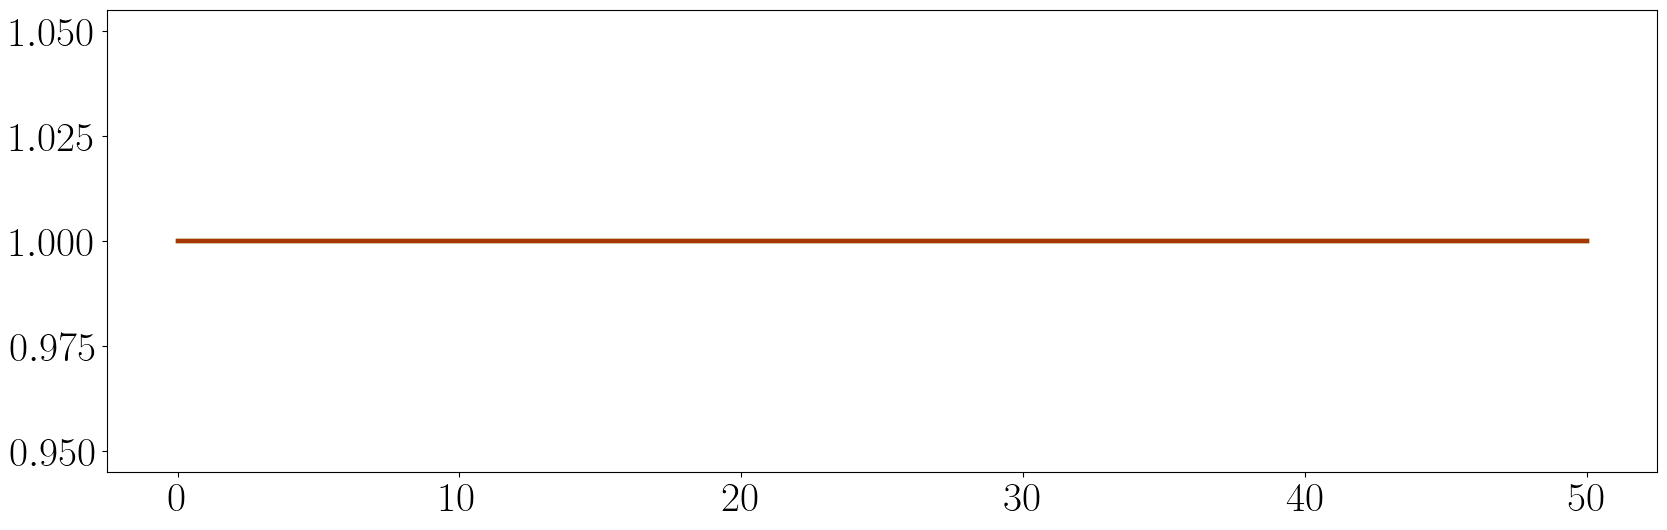

In [30]:
colors_GTN = ['#edf8e9',
              '#bae4b3',
              '#74c476',
              '#31a354',
              '#006d2c']
colors_KNN = ['#feedde',
              '#fdbe85',
              '#fd8d3c',
              '#e6550d',
              '#a63603']

alpha, alpha_bounds = 0.1, 1
lw = 2

fontsize = 30

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, ax = plt.subplots(1,1,figsize=(20,6))

# ax.bar(np.arange(total_networks), prop_significant, lw=0,
#        color=[cmap(i/(total_networks-1)) for i in range(total_networks)])

for i_density in range(len(densities)):
  color = colors_GTN[i_density]
  ax.plot(prop_significant_dict[densities[i_density]], lw=3, color=color)

for i_k in range(len(ks)):
  color = colors_KNN[i_k]
  ax.plot(prop_significant_dict[ks[i_k]], lw=3, color=color)

# xticks = np.arange(7,len(dates),10)
# xticklabels = [dates[i].split('-')[1] for i in xticks]
# ax.set_xticks(xticks)

plt.show()

In [35]:
np.logspace(-2,0,100)

array([0.01      , 0.01047616, 0.01097499, 0.01149757, 0.01204504, 0.01261857, 0.01321941, 0.01384886, 0.01450829, 0.01519911, 0.01592283, 0.01668101, 0.01747528, 0.01830738, 0.0191791 , 0.02009233, 0.02104904, 0.02205131, 0.0231013 , 0.02420128,
       0.02535364, 0.02656088, 0.02782559, 0.02915053, 0.03053856, 0.03199267, 0.03351603, 0.03511192, 0.0367838 , 0.03853529, 0.04037017, 0.04229243, 0.04430621, 0.04641589, 0.04862602, 0.05094138, 0.05336699, 0.0559081 , 0.05857021, 0.06135907,
       0.06428073, 0.06734151, 0.07054802, 0.07390722, 0.07742637, 0.08111308, 0.08497534, 0.08902151, 0.09326033, 0.097701  , 0.1023531 , 0.10722672, 0.1123324 , 0.1176812 , 0.12328467, 0.12915497, 0.13530478, 0.14174742, 0.14849683, 0.15556761,
       0.16297508, 0.17073526, 0.17886495, 0.18738174, 0.19630407, 0.20565123, 0.21544347, 0.22570197, 0.23644894, 0.24770764, 0.25950242, 0.27185882, 0.28480359, 0.29836472, 0.31257158, 0.32745492, 0.34304693, 0.35938137, 0.37649358, 0.39442061,
       0.413

In [37]:
pval_threshs = np.logspace(-2,0,50)
prop_under_thresh = [None]*total_networks


for i in trange(total_networks, leave=False):
  prop_under_thresh[i] = [None]*len(pval_threshs)

  with gzip.open(f'{corr_dir}/{i}.data', 'rb') as file:
    corr_mat = pkl.load(file)
    pval_mat = pkl.load(file)

  pvals = pval_mat[np.triu_indices(num_nodes,1)]

  for j in trange(len(pval_threshs), leave=False):
    pval_thresh = pval_threshs[j]

    prop_under_thresh[i][j] = len(np.where(pvals <= pval_thresh)[0])/len(pvals)

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [43]:
min([prop_under_thresh[i][np.argmin(np.abs(pval_threshs-0.05))] for i in range(total_networks)])

0.5997520677278068

  0%|          | 0/51 [00:00<?, ?it/s]

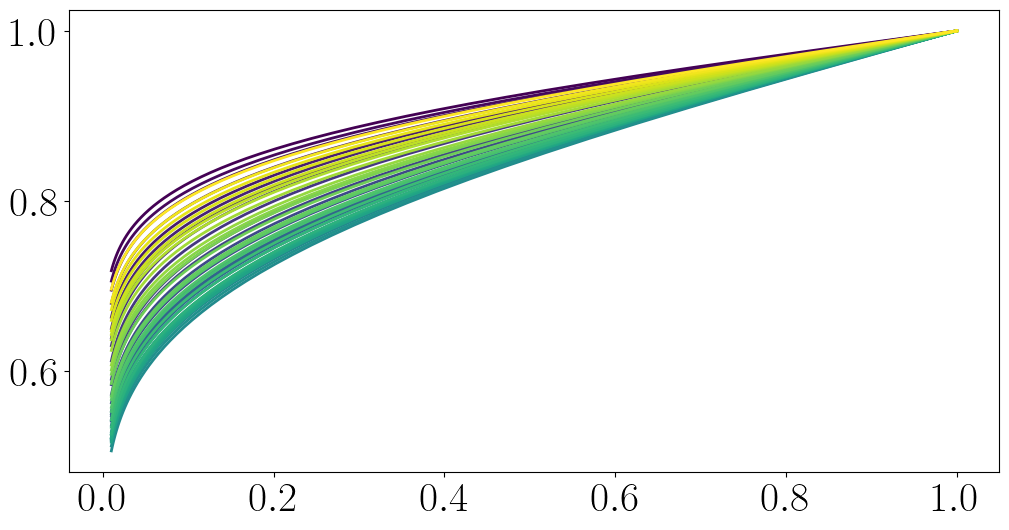

In [39]:
cmap = mpl.cm.viridis

alpha, alpha_bounds = 0.1, 1
lw = 2

fontsize = 30

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, ax = plt.subplots(1,1,figsize=(12,6))

for i in trange(total_networks, leave=False):
  color = cmap(i/(total_networks-1))

  ax.plot(pval_threshs, prop_under_thresh[i],color=color,lw=lw,alpha=alpha_bounds)

plt.show()

  0%|          | 0/51 [00:00<?, ?it/s]

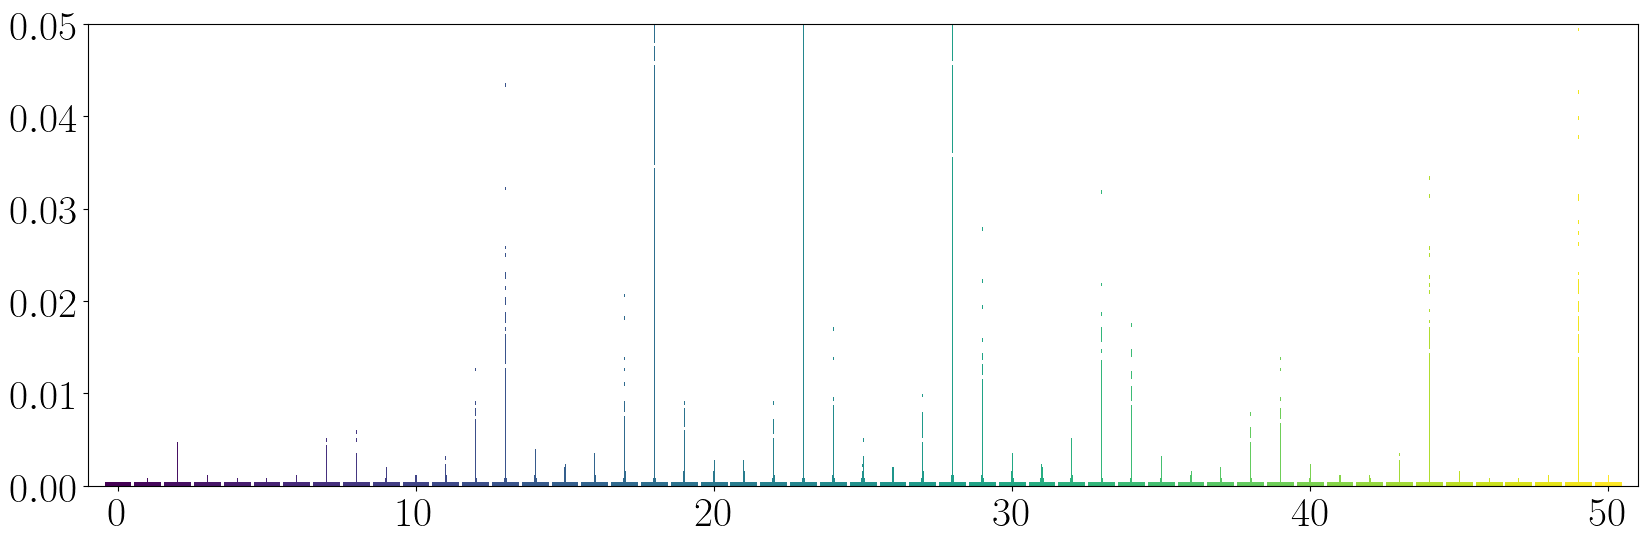

In [ ]:
cmap = mpl.cm.viridis

alpha, alpha_bounds = 0.1, 1
lw = 2

fontsize = 30

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

def add_rect_to_plot(left,bottom,width,height,color,ax=None,alpha=1,zorder=None):
    if zorder is None:
        rect=mpatches.Rectangle((left,bottom),width,height,fill=True,
                            facecolor=color,linewidth=0,edgecolor=color,alpha=alpha)#,facecolor=color)
    else:
        rect=mpatches.Rectangle((left,bottom),width,height,fill=True,zorder=zorder,
                            facecolor=color,linewidth=0,edgecolor=color,alpha=alpha)
    if ax is None:
        plt.gca().add_patch(rect)
    else:
        ax.add_patch(rect)

fig, ax = plt.subplots(1,1,figsize=(20,6))

ymin, ymax = float('inf'), -float('inf')

for i in trange(total_networks):
  color = cmap(i/(total_networks-1))

  # with gzip.open(f'{pval_dir}/{i}.data', 'rb') as file:
  #   pval_mat = pkl.load(file)

  ymin = min(ymin, np.min(pvals[:,i]))
  ymax = max(ymax, np.max(pvals[:,i]))

  hist, bin_edges = np.histogram(pvals[np.triu_indices(num_nodes,1),i],
                                 bins=2500, density=True)
  hist = 0.9*hist/max(hist)

  for j in range(len(bin_edges)-1):
    add_rect_to_plot(i-hist[j]/2, bin_edges[j], hist[j],
                     bin_edges[j+1]-bin_edges[j], color, ax=ax)


  # ax.violinplot([pval_mat[np.triu_indices(num_nodes,1)]], positions=[i], vert=True, widths=0.5,
  #               showmeans=False, showextrema=True, showmedians=False,
  #               quantiles=None, points=100, bw_method=None)

ymax = 0.05

ax.set_ylim(ymin, ymax)
ax.set_xlim(-1,total_networks)
plt.show()

  0%|          | 0/51 [00:00<?, ?it/s]

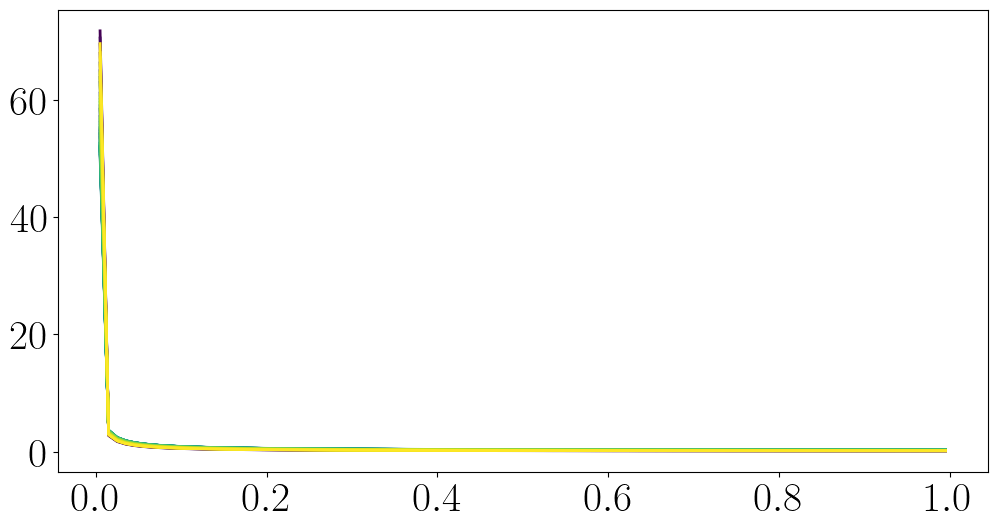

In [ ]:
cmap = mpl.cm.viridis

alpha, alpha_bounds = 0.1, 1
lw = 2

fontsize = 30

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, ax = plt.subplots(1,1,figsize=(12,6))

for i in trange(total_networks, leave=False):
  color = cmap(i/(total_networks-1))



  max_val = max(abs(np.min(pvals[:,i])), np.max(pvals[:,i]))
  min_val = -max_val
  # pts = np.linspace(min_val, max_val, 100)

  # kernel = sp.stats.gaussian_kde(corr_mat[np.triu_indices(len(corr_mat),1)])

  # kde = kernel.evaluate(pts)

  kde, bin_edges = np.histogram(pvals[:,i], bins=100, density=True)
  pts = np.array([(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])


  # ax.fill_between(pts,0,kde,color=color,alpha=alpha)
  # med = np.median(corr_mat.flatten())
  # ax.plot([med]*2,[0,kde[np.argmin(np.abs(pts - med))]],color=color,lw=2,alpha=alpha_bounds)
  ax.plot(pts,kde,color=color,lw=lw,alpha=alpha_bounds)

plt.show()

  0%|          | 0/51 [00:00<?, ?it/s]

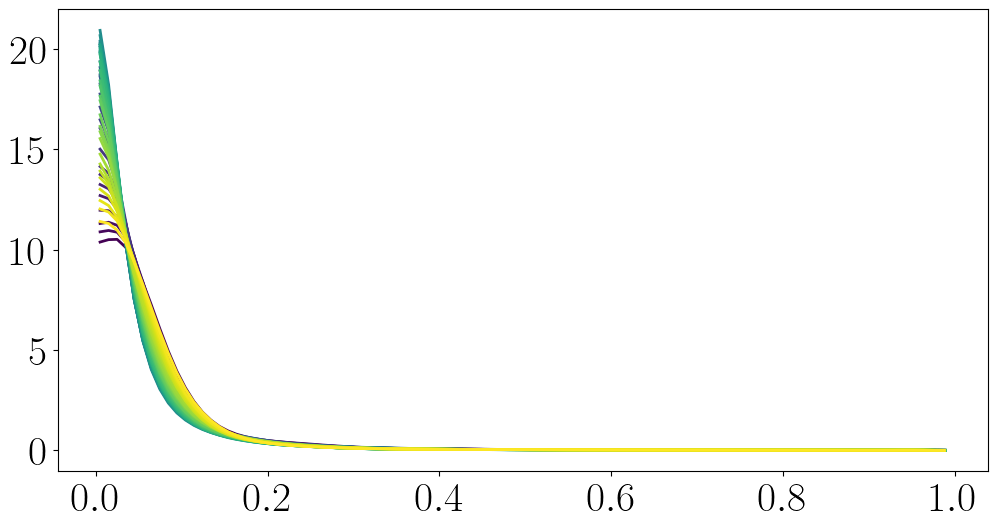

In [ ]:
cmap = mpl.cm.viridis

alpha, alpha_bounds = 0.1, 1
lw = 2

fontsize = 30

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, ax = plt.subplots(1,1,figsize=(12,6))

for i in trange(total_networks, leave=False):
  color = cmap(i/(total_networks-1))



  max_val = max(abs(np.min(corr_mat)), np.max(corr_mat))
  min_val = -max_val
  # pts = np.linspace(min_val, max_val, 100)

  # kernel = sp.stats.gaussian_kde(corr_mat[np.triu_indices(len(corr_mat),1)])

  # kde = kernel.evaluate(pts)

  kde, bin_edges = np.histogram(corrs[:,i], bins=100, density=True)
  pts = np.array([(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])


  # ax.fill_between(pts,0,kde,color=color,alpha=alpha)
  # med = np.median(corr_mat.flatten())
  # ax.plot([med]*2,[0,kde[np.argmin(np.abs(pts - med))]],color=color,lw=2,alpha=alpha_bounds)
  ax.plot(pts,kde,color=color,lw=lw,alpha=alpha_bounds)

plt.show()

0.0025


  0%|          | 0/51 [00:00<?, ?it/s]

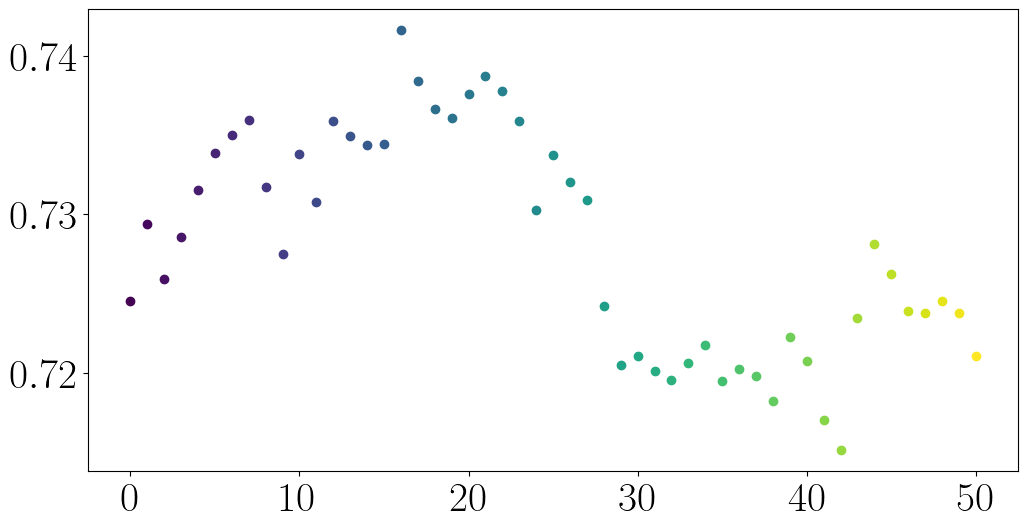

0.005


  0%|          | 0/51 [00:00<?, ?it/s]

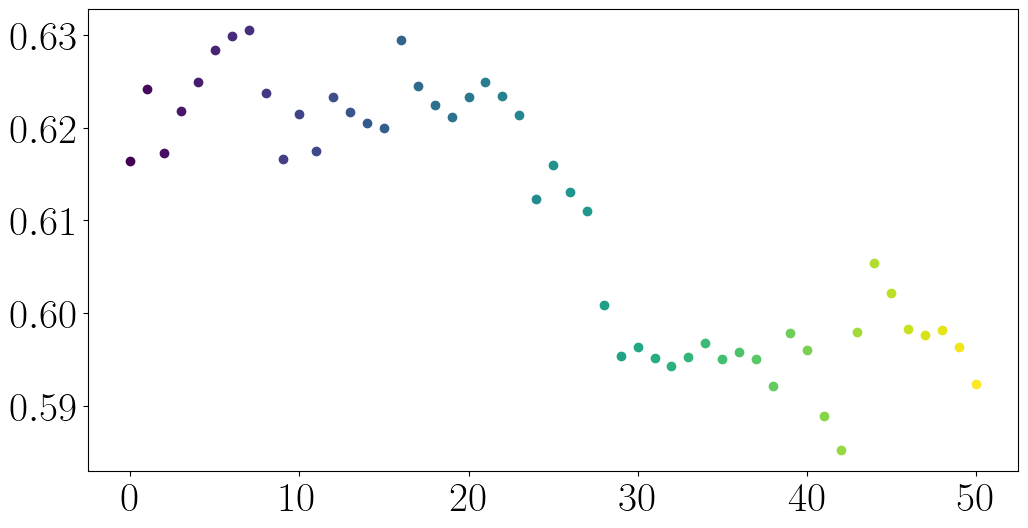

0.025


  0%|          | 0/51 [00:00<?, ?it/s]

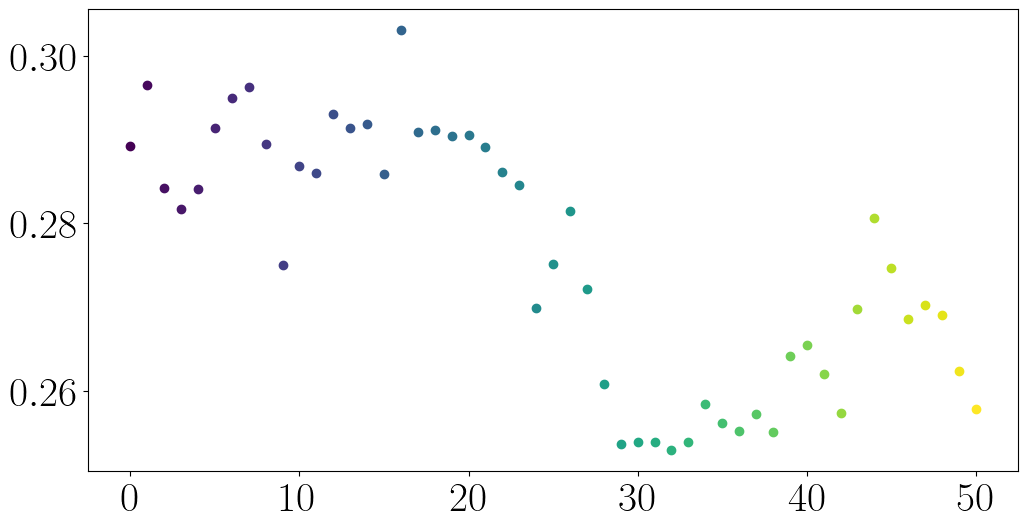

0.05


  0%|          | 0/51 [00:00<?, ?it/s]

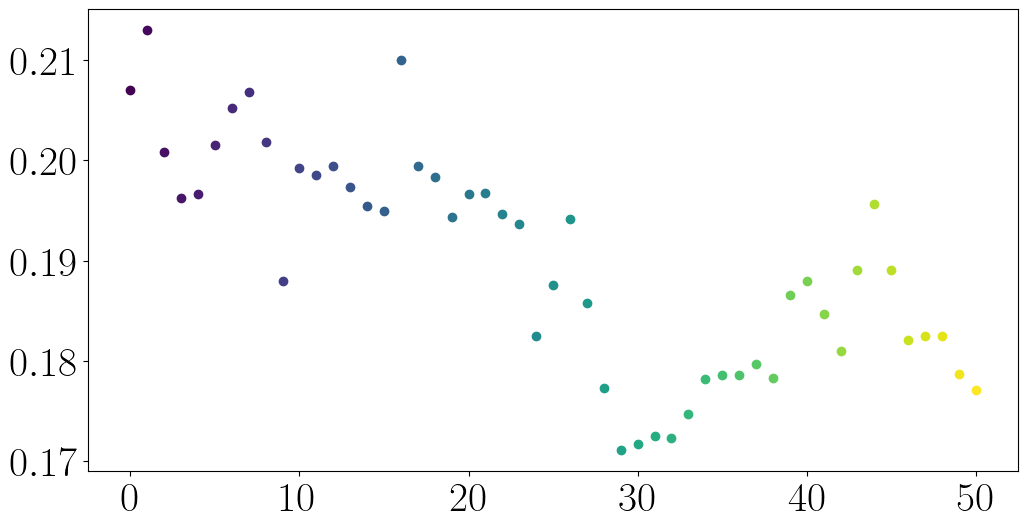

0.1


  0%|          | 0/51 [00:00<?, ?it/s]

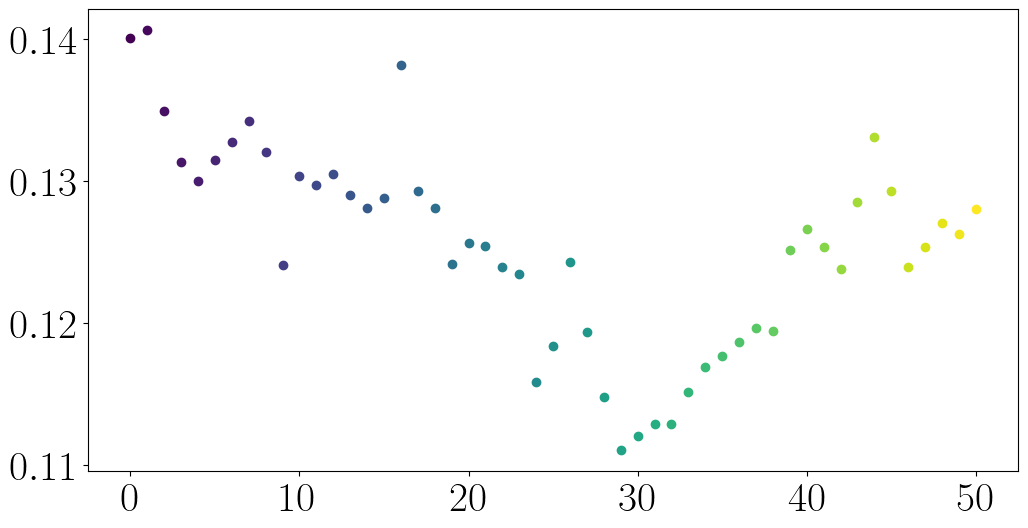

In [ ]:
for density in [0.0025, 0.005, 0.025, 0.05, 0.1]:
  print(density)

  cmap = mpl.cm.viridis

  alpha, alpha_bounds = 0.1, 1
  lw = 2

  fontsize = 30

  plt.rc('text', usetex=True)
  plt.rc('xtick',labelsize=fontsize)
  plt.rc('ytick',labelsize=fontsize)

  fig, ax = plt.subplots(1,1,figsize=(12,6))

  for i in trange(total_networks, leave=False):
    color = cmap(i/(total_networks-1))

    k = int(density*(num_nodes*(num_nodes-1)/2))
    ax.plot(i,np.partition(corrs[:,i], -k)[-k],'o',color=color,lw=lw,alpha=alpha_bounds)

  plt.show()

In [ ]:
hist

array([5403978, 5467060, 5474158, 5268070, 4885718, 4370240, 3778977,
       3161529, 2575257, 2057735, 1627114, 1272643,  994094,  784289,
        621850,  505964,  419390,  356931,  310228,  274827,  244735,
        222589,  202331,  182439,  163763,  146149,  130703,  116118,
        101064,   87860,   76951,   66583,   57816,   51240,   46056,
         41639,   38195,   35481,   33979,   32008,   30509,   29994,
         28732,   27748,   26822,   25758,   25014,   24432,   23097,
         22513,   22248,   21463,   20898,   20272,   19903,   19273,
         18792,   18137,   17404,   17104,   16402,   15981,   15366,
         15078,   14375,   13715,   13028,   12075,   11046,   10396,
          9696,    9286,    8750,    8270,    7754,    7459,    7041,
          6593,    6533,    6486,    6127,    5903,    5725,    5331,
          5043,    4833,    4416,    4136,    3921,    3745,    3725,
          3580,    3676,    4230,    4899,    4849,    3938,    2247,
           537,     

## Find edge lists - EFFICIENT IF DENSITY IS VERY LOW

In [ ]:
def save_edge_list(edge_list, j, edge_dir):
  edge_list = edge_list.astype(np.int32)

  with gzip.open(edge_dir + str(j) + '.data', 'wb') as file:
    pkl.dump(edge_list, file)
  # for i in len(edge_list):
  #   edge_list[i] = [str(edge_list[i][0]), str(edge_list[i][1])]

  # with open(edge_dir + str(j) + '.csv', 'a') as file:
  #   file.writelines(edge_list)

def make_edge_list(j, data, edge_dir, offset, months, density, save_corr=False,
                   multi=True):
  # data=data[:,(offset*j):((months*30)+(offset*j))]

  correlation = np.abs(np.corrcoef(data))

  k = int(density*(len(correlation)*(len(correlation)-1)/2))
  threshold = np.partition(correlation[np.triu_indices(len(data), 1)], -k)[-k]

  # pre-allocate to avoid copies
  edge_list = np.zeros((int(density*(correlation.shape[0]*(correlation.shape[0]-1)/2)), 2))
  # edge_list = [[None,None]]*int(density*(correlation.shape[0]*(correlation.shape[0]-1)/2) + 1)
  # print(edge_list)
  # print(len(edge_list)/(len(data)*(len(data)-1)/2), density)
  i = 0
  for row in trange(correlation.shape[0], leave=False, desc=str(j)):
    for col in range(row+1, correlation.shape[0]):
      if correlation[row,col] >= threshold:
        # edge_list.append([str(row),str(col)])
        edge_list[i, 0] = row
        edge_list[i, 1] = col
        # edge_list[i][0] = row
        # edge_list[i][1] = col
        # if i % 100000:
        #   print(edge_list[i])
        i += 1
    # if row % 10 == 0:
    #   print(edge_list[i-1])


  # correlation[correlation <= threshold] = 0
  # correlation[correlation > threshold] = 1

  # np.fill_diagonal(correlation,0)
  # print(np.sum(A)/(N*(N-1))*100)

  if multi:
    try:
      save_edge_list(edge_list, j, edge_dir)
    except:
      print('Could not save matrix: '+str(j))

    return j, len(edge_list)/(len(data)*(len(data)-1)/2), len(np.where(edge_list[:,1] > 0)[0])/(len(data)*(len(data)-1)/2), edge_list[-1]
  else:
    return edge_list


def make_edge_list_knn(j, data, edge_dir, offset, months, k, multi=True):
  # data=data[:,(offset*j):((months*30)+(offset*j))]

  correlation = np.abs(np.corrcoef(data))
  np.fill_diagonal(correlation, 0)

  num_nodes = len(correlation)
  num_edges = 0

  edge_list = np.zeros((int(k*num_nodes), 2))

  for node in range(num_nodes):
    inds = np.argpartition(correlation[node,:], -k)[-k:]
    num_edges += len(inds)
    edge_list[node*k:(node+1)*k] = sorted([[node,n] for n in inds])

  if multi:
    try:
      save_edge_list(edge_list, j, edge_dir)
    except:
      print('Could not save matrix: '+str(j))



    return j, num_edges
  else:
    return edge_list

In [ ]:
!pip install multiprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached multiprocessing-2.6.2.1.tar.gz (108 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# months=int(input('window of one netwok in terms of months='))
# offset=int(input('offset of networks in days='))
# months = 12
# offset = 30
months = 300 #length of windows in months
offset = 365.25 #offset b/w windows in days



# total_networks = int((np.shape(icosahedral_data)[1]-int(months*365/12))/offset)+1
total_networks = round((np.shape(icosahedral_data)[1]-(months*365.25/12))/offset)+1
# density = 0.25
density = 0.1 #density of edges in graph

# Save time intervals
date_intervals = []
year_intervals = []
for i in range(total_networks):
  date_start = time[round(i*offset)]
  date_end = time[round((months*365.25/12)+(offset*i))-1]
  date_intervals.append([date_start, date_end])

  dates_start = [datetime.strptime('01/01/'+date_start.split('/')[-1], '%m/%d/%Y'),
                 datetime.strptime('01/01/'+str(int(date_start.split('/')[-1])-1), '%m/%d/%Y'),
                 datetime.strptime('01/01/'+str(int(date_start.split('/')[-1])+1), '%m/%d/%Y')]
  ind_start = np.argmin(np.abs([date.timestamp() - datetime.strptime(date_start, '%m/%d/%Y').timestamp() for date in dates_start]))
  year_start = dates_start[ind_start].strftime('%Y')

  dates_end = [datetime.strptime('01/01/'+date_end.split('/')[-1], '%m/%d/%Y'),
               datetime.strptime('01/01/'+str(int(date_end.split('/')[-1])-1), '%m/%d/%Y'),
               datetime.strptime('01/01/'+str(int(date_end.split('/')[-1])+1), '%m/%d/%Y')]
  ind_end = np.argmin(np.abs([date.timestamp() - datetime.strptime(date_end, '%m/%d/%Y').timestamp() for date in dates_end]))
  year_end = dates_end[ind_end].strftime('%Y')
  year_intervals.append([year_start, year_end])

  # print(date_start+'-'+date_end, year_start+'-'+year_end)


with gzip.open(data_dir + 'date_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'wb') as file:
  pkl.dump(date_intervals,file)

with gzip.open(data_dir + 'year_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'wb') as file:
  pkl.dump(year_intervals,file)



existing_iters = []
edge_dir = data_dir + 'edge_list-months='+str(months)+',offset='+str(offset)+',density='+str(density)+'/' # or something like this
if not os.path.isdir(edge_dir):
  os.mkdir(edge_dir)
# else:
#   for filename in sorted(os.listdir(edge_dir), key = lambda k: int(k.replace('.data', ''))):
#     if os.path.getsize(edge_dir + filename) > 1e6:
#       existing_iters += [int(filename.replace('.data',''))]

# print(existing_iters)

parallel = True

if not parallel:
  for j in trange(total_networks):
    if j not in existing_iters:
      edge_list = make_edge_list(j, icosahedral_data[:,round(j*offset):round((months*365.25/12)+(offset*j))],
                                edge_dir, offset, months, density, multi=False)
      data = icosahedral_data[:,round(j*offset):round((months*365.25/12)+(offset*j))]
      print(len(edge_list)/(len(data)*(len(data)-1)/2), len(np.where(edge_list[:,1] > 0)[0])/(len(data)*(len(data)-1)/2), edge_list[-1])
else:
  import multiprocessing as mp

  def handle_error(error):
      print(error)

  n_tasks = 4
  pool = mp.Pool(n_tasks)

  jobs = [pool.apply_async(make_edge_list,
                          args=[j, icosahedral_data[:,round(j*offset):round((months*365.25/12)+(offset*j))],
                                edge_dir, offset, months, density, True],
                          error_callback=handle_error) for j in range(total_networks) if j not in existing_iters]
  pool.close()

  result_lst = []
  lst = tqdm(jobs)
  for job in lst:
      j, est_density, true_density, last_entry = job.get()
      print(j, est_density, true_density, last_entry)
      result_lst.append(j)
      try:
        lst.set_description(str(j))
      except:
        pass

  pool.join()

  0%|          | 0/51 [00:01<?, ?it/s]

0 0.09999999809321003 0.09999999809321003 [10239. 10241.]
1 0.09999999809321003 0.09999999809321003 [10239. 10241.]
2 0.09999999809321003 0.09999999809321003 [10239. 10241.]
3 0.09999999809321003 0.09999999809321003 [10239. 10241.]
4 0.09999999809321003 0.09999999809321003 [10239. 10241.]
5 0.09999999809321003 0.09999999809321003 [10239. 10241.]
6 0.09999999809321003 0.09999999809321003 [10239. 10241.]
7 0.09999999809321003 0.09999999809321003 [10239. 10241.]
8 0.09999999809321003 0.09999999809321003 [10239. 10241.]
9 0.09999999809321003 0.09999999809321003 [10239. 10241.]
10 0.09999999809321003 0.09999999809321003 [10239. 10241.]
11 0.09999999809321003 0.09999999809321003 [10239. 10241.]
12 0.09999999809321003 0.09999999809321003 [10239. 10241.]
13 0.09999999809321003 0.09999999809321003 [10239. 10241.]
14 0.09999999809321003 0.09999999809321003 [10239. 10241.]
15 0.09999999809321003 0.09999999809321003 [10239. 10241.]
16 0.09999999809321003 0.09999999809321003 [10239. 10241.]
17 0.09

In [ ]:
# months=int(input('window of one netwok in terms of months='))
# offset=int(input('offset of networks in days='))
# months = 12
# offset = 30
months = 300
offset = 365.25



# total_networks = int((np.shape(icosahedral_data)[1]-int(months*365/12))/offset)+1
total_networks = round((np.shape(icosahedral_data)[1]-(months*365.25/12))/offset)+1
# k = 0.25

ks = [1000]

for k in ks:

  # Save time intervals
  date_intervals = []
  year_intervals = []
  for i in range(total_networks):
    date_start = time[round(i*offset)]
    date_end = time[round((months*365.25/12)+(offset*i))-1]
    date_intervals.append([date_start, date_end])

    dates_start = [datetime.strptime('01/01/'+date_start.split('/')[-1], '%m/%d/%Y'),
                  datetime.strptime('01/01/'+str(int(date_start.split('/')[-1])-1), '%m/%d/%Y'),
                  datetime.strptime('01/01/'+str(int(date_start.split('/')[-1])+1), '%m/%d/%Y')]
    ind_start = np.argmin(np.abs([date.timestamp() - datetime.strptime(date_start, '%m/%d/%Y').timestamp() for date in dates_start]))
    year_start = dates_start[ind_start].strftime('%Y')

    dates_end = [datetime.strptime('01/01/'+date_end.split('/')[-1], '%m/%d/%Y'),
                datetime.strptime('01/01/'+str(int(date_end.split('/')[-1])-1), '%m/%d/%Y'),
                datetime.strptime('01/01/'+str(int(date_end.split('/')[-1])+1), '%m/%d/%Y')]
    ind_end = np.argmin(np.abs([date.timestamp() - datetime.strptime(date_end, '%m/%d/%Y').timestamp() for date in dates_end]))
    year_end = dates_end[ind_end].strftime('%Y')
    year_intervals.append([year_start, year_end])

    # print(date_start+'-'+date_end, year_start+'-'+year_end)


  with gzip.open(data_dir + 'date_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'wb') as file:
    pkl.dump(date_intervals,file)

  with gzip.open(data_dir + 'year_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'wb') as file:
    pkl.dump(year_intervals,file)



  existing_iters = []
  edge_dir = data_dir + 'edge_list-months='+str(months)+',offset='+str(offset)+',k='+str(k)+'/' # or something like this
  if not os.path.isdir(edge_dir):
    os.mkdir(edge_dir)
  # else:
  #   for filename in sorted(os.listdir(edge_dir), key = lambda k: int(k.replace('.data', ''))):
  #     if os.path.getsize(edge_dir + filename) > 1e6:
  #       existing_iters += [int(filename.replace('.data',''))]

  # print(existing_iters)

  parallel = True

  if not parallel:
    for j in trange(total_networks):
      if j not in existing_iters:
        edge_list = make_edge_list_knn(j, icosahedral_data[:,round(j*offset):round((months*365.25/12)+(offset*j))],
                                  edge_dir, offset, months, k, multi=False)
        data = icosahedral_data[:,round(j*offset):round((months*365.25/12)+(offset*j))]
        print(len(edge_list)/(len(data)*(len(data)-1)/2), len(np.where(edge_list[:,1] > 0)[0])/(len(data)*(len(data)-1)/2), edge_list[-1])
  else:
    import multiprocessing as mp

    def handle_error(error):
        print(error)

    n_tasks = 4
    pool = mp.Pool(n_tasks)

    jobs = [pool.apply_async(make_edge_list_knn,
                            args=[j, icosahedral_data[:,round(j*offset):round((months*365.25/12)+(offset*j))],
                                  edge_dir, offset, months, k, True],
                            error_callback=handle_error) for j in range(total_networks) if j not in existing_iters]
    pool.close()

    result_lst = []
    lst = tqdm(jobs)
    for job in lst:
        j, num_edges = job.get()
        print(j, num_edges)
        result_lst.append(j)
        try:
          lst.set_description(str(j))
        except:
          pass

    pool.join()

  0%|          | 0/51 [00:01<?, ?it/s]

0 10242000
1 10242000
2 10242000
3 10242000
4 10242000
5 10242000
6 10242000
7 10242000
8 10242000
9 10242000
10 10242000
11 10242000
12 10242000
13 10242000
14 10242000
15 10242000
16 10242000
17 10242000
18 10242000
19 10242000
20 10242000
21 10242000
22 10242000
23 10242000
24 10242000
25 10242000
26 10242000
27 10242000
28 10242000
29 10242000
30 10242000
31 10242000
32 10242000
33 10242000
34 10242000
35 10242000
36 10242000
37 10242000
38 10242000
39 10242000
40 10242000
41 10242000
42 10242000
43 10242000
44 10242000
45 10242000
46 10242000
47 10242000
48 10242000
49 10242000
50 10242000


In [ ]:
# months=int(input('window of one netwok in terms of months='))
# offset=int(input('offset of networks in days='))
# months = 12
# offset = 30
months = 300
offset = 365.25



# total_networks = int((np.shape(icosahedral_data)[1]-int(months*365/12))/offset)+1
total_networks = round((np.shape(icosahedral_data)[1]-(months*365.25/12))/offset)+1
# density = 0.25

densities = [0.05, 0.025, 0.01, 0.005]

for density in densities:

  # Save time intervals
  date_intervals = []
  year_intervals = []
  for i in range(total_networks):
    date_start = time[round(i*offset)]
    date_end = time[round((months*365.25/12)+(offset*i))-1]
    date_intervals.append([date_start, date_end])

    dates_start = [datetime.strptime('01/01/'+date_start.split('/')[-1], '%m/%d/%Y'),
                  datetime.strptime('01/01/'+str(int(date_start.split('/')[-1])-1), '%m/%d/%Y'),
                  datetime.strptime('01/01/'+str(int(date_start.split('/')[-1])+1), '%m/%d/%Y')]
    ind_start = np.argmin(np.abs([date.timestamp() - datetime.strptime(date_start, '%m/%d/%Y').timestamp() for date in dates_start]))
    year_start = dates_start[ind_start].strftime('%Y')

    dates_end = [datetime.strptime('01/01/'+date_end.split('/')[-1], '%m/%d/%Y'),
                datetime.strptime('01/01/'+str(int(date_end.split('/')[-1])-1), '%m/%d/%Y'),
                datetime.strptime('01/01/'+str(int(date_end.split('/')[-1])+1), '%m/%d/%Y')]
    ind_end = np.argmin(np.abs([date.timestamp() - datetime.strptime(date_end, '%m/%d/%Y').timestamp() for date in dates_end]))
    year_end = dates_end[ind_end].strftime('%Y')
    year_intervals.append([year_start, year_end])

    # print(date_start+'-'+date_end, year_start+'-'+year_end)


  with gzip.open(data_dir + 'date_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'wb') as file:
    pkl.dump(date_intervals,file)

  with gzip.open(data_dir + 'year_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'wb') as file:
    pkl.dump(year_intervals,file)



  existing_iters = []
  edge_dir = data_dir + 'edge_list-months='+str(months)+',offset='+str(offset)+',density='+str(density)+'/' # or something like this
  if not os.path.isdir(edge_dir):
    os.mkdir(edge_dir)
  # else:
  #   for filename in sorted(os.listdir(edge_dir), key = lambda k: int(k.replace('.data', ''))):
  #     if os.path.getsize(edge_dir + filename) > 1e6:
  #       existing_iters += [int(filename.replace('.data',''))]

  # print(existing_iters)

  parallel = True

  if not parallel:
    for j in trange(total_networks):
      if j not in existing_iters:
        edge_list = make_edge_list(j, icosahedral_data[:,round(j*offset):round((months*365.25/12)+(offset*j))],
                                  edge_dir, offset, months, density, multi=False)
        data = icosahedral_data[:,round(j*offset):round((months*365.25/12)+(offset*j))]
        print(len(edge_list)/(len(data)*(len(data)-1)/2), len(np.where(edge_list[:,1] > 0)[0])/(len(data)*(len(data)-1)/2), edge_list[-1])
  else:
    import multiprocessing as mp

    def handle_error(error):
        print(error)

    n_tasks = 4
    pool = mp.Pool(n_tasks)

    jobs = [pool.apply_async(make_edge_list,
                            args=[j, icosahedral_data[:,round(j*offset):round((months*365.25/12)+(offset*j))],
                                  edge_dir, offset, months, density, True],
                            error_callback=handle_error) for j in range(total_networks) if j not in existing_iters]
    pool.close()

    result_lst = []
    lst = tqdm(jobs)
    for job in lst:
        j, est_density, true_density, last_entry = job.get()
        print(j, est_density, true_density, last_entry)
        result_lst.append(j)
        try:
          lst.set_description(str(j))
        except:
          pass

    pool.join()

In [ ]:
print(date_intervals)

[['01/01/1948', '12/30/1972'], ['12/31/1948', '12/30/1973'], ['12/31/1949', '12/31/1974'], ['01/01/1951', '12/31/1975'], ['01/01/1952', '12/30/1976'], ['12/31/1952', '12/31/1977'], ['01/01/1954', '12/31/1978'], ['01/01/1955', '12/31/1979'], ['01/01/1956', '12/30/1980'], ['12/31/1956', '12/30/1981'], ['12/31/1957', '12/31/1982'], ['01/01/1959', '12/31/1983'], ['01/01/1960', '12/30/1984'], ['12/31/1960', '12/31/1985'], ['01/01/1962', '12/31/1986'], ['01/01/1963', '12/31/1987'], ['01/01/1964', '12/30/1988'], ['12/31/1964', '12/30/1989'], ['12/31/1965', '12/31/1990'], ['01/01/1967', '12/31/1991'], ['01/01/1968', '12/30/1992'], ['12/31/1968', '12/31/1993'], ['01/01/1970', '12/31/1994'], ['01/01/1971', '12/31/1995'], ['01/01/1972', '12/30/1996'], ['12/31/1972', '12/30/1997'], ['12/31/1973', '12/31/1998'], ['01/01/1975', '12/31/1999'], ['01/01/1976', '12/30/2000'], ['12/31/1976', '12/31/2001'], ['01/01/1978', '12/31/2002'], ['01/01/1979', '12/31/2003'], ['01/01/1980', '12/30/2004'], ['12/31/1

In [ ]:
# months=int(input('window of one netwok in terms of months='))
# offset=int(input('offset of networks in days='))
# months = 12
# offset = 30
months = 300
offset = 365.25



# total_networks = int((np.shape(icosahedral_data)[1]-int(months*365/12))/offset)+1
total_networks = round((np.shape(icosahedral_data)[1]-(months*365.25/12))/offset)+1
# density = 0.25
densities = [0.05, 0.1, 0.15, 0.2, 0.25]

# Save time intervals
date_intervals = []
year_intervals = []
for i in range(total_networks):
  date_start = time[round(i*offset)]
  date_end = time[round((months*365.25/12)+(offset*i))-1]
  date_intervals.append([date_start, date_end])

  dates_start = [datetime.strptime('01/01/'+date_start.split('/')[-1], '%m/%d/%Y'),
                 datetime.strptime('01/01/'+str(int(date_start.split('/')[-1])-1), '%m/%d/%Y'),
                 datetime.strptime('01/01/'+str(int(date_start.split('/')[-1])+1), '%m/%d/%Y')]
  ind_start = np.argmin(np.abs([date.timestamp() - datetime.strptime(date_start, '%m/%d/%Y').timestamp() for date in dates_start]))
  year_start = dates_start[ind_start].strftime('%Y')

  dates_end = [datetime.strptime('01/01/'+date_end.split('/')[-1], '%m/%d/%Y'),
               datetime.strptime('01/01/'+str(int(date_end.split('/')[-1])-1), '%m/%d/%Y'),
               datetime.strptime('01/01/'+str(int(date_end.split('/')[-1])+1), '%m/%d/%Y')]
  ind_end = np.argmin(np.abs([date.timestamp() - datetime.strptime(date_end, '%m/%d/%Y').timestamp() for date in dates_end]))
  year_end = dates_end[ind_end].strftime('%Y')
  year_intervals.append([year_start, year_end])

  # print(date_start+'-'+date_end, year_start+'-'+year_end)


with gzip.open(data_dir + 'date_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'wb') as file:
  pkl.dump(date_intervals,file)

with gzip.open(data_dir + 'year_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'wb') as file:
  pkl.dump(year_intervals,file)



for density in densities:
  existing_iters = []
  edge_dir = data_dir + 'edge_list-months='+str(months)+',offset='+str(offset)+',density={:.2f}'.format(density)+'/'
  if not os.path.isdir(edge_dir):
    os.mkdir(edge_dir)
  else:
    for filename in sorted(os.listdir(edge_dir), key = lambda k: int(k.replace('.data', ''))):
      if os.path.getsize(edge_dir + filename) > 1e6:
        existing_iters += [int(filename.replace('.data',''))]

  # print(existing_iters)

  parallel = True

  if not parallel:
    for j in trange(total_networks):
      if j not in existing_iters:
        edge_list = make_edge_list(j, icosahedral_data[:,round(j*offset):round((months*365.25/12)+(offset*j))],
                                  edge_dir, offset, months, density)
  else:
    import multiprocessing as mp

    def handle_error(error):
        print(error)

    n_tasks = 4
    pool = mp.Pool(n_tasks)

    jobs = [pool.apply_async(make_edge_list,
                            args=[j, icosahedral_data[:,round(j*offset):round((months*365.25/12)+(offset*j))],
                                  edge_dir, offset, months, density],
                            error_callback=handle_error) for j in range(total_networks) if j not in existing_iters]
    pool.close()

    result_lst = []
    lst = tqdm(jobs, desc='Density = {:.2f}'.format(density))
    for job in lst:
        j = job.get()
        result_lst.append(j)
        try:
          lst.set_description('Density = {:.2f}'.format(density)+', '+str(j))
        except:
          pass

    pool.join()

Density = 0.05:   0%|          | 0/39 [00:00<?, ?it/s]

Density = 0.10:   0%|          | 0/50 [00:04<?, ?it/s]

Density = 0.15:   0%|          | 0/50 [00:03<?, ?it/s]

Density = 0.20:   0%|          | 0/50 [00:00<?, ?it/s]

Density = 0.25:   0%|          | 0/50 [00:03<?, ?it/s]

In [ ]:
date_intervals = []
year_intervals = []
for i in range(total_networks):
  date_start = time[round(i*offset)]
  date_end = time[round((months*365.25/12)+(offset*i))-1]
  date_intervals.append([date_start, date_end])

  dates_start = [datetime.strptime('01/01/'+date_start.split('/')[-1], '%m/%d/%Y'),
                 datetime.strptime('01/01/'+str(int(date_start.split('/')[-1])-1), '%m/%d/%Y'),
                 datetime.strptime('01/01/'+str(int(date_start.split('/')[-1])+1), '%m/%d/%Y')]
  ind_start = np.argmin(np.abs([date.timestamp() - datetime.strptime(date_start, '%m/%d/%Y').timestamp() for date in dates_start]))
  year_start = dates_start[ind_start].strftime('%Y')

  dates_end = [datetime.strptime('01/01/'+date_end.split('/')[-1], '%m/%d/%Y'),
               datetime.strptime('01/01/'+str(int(date_end.split('/')[-1])-1), '%m/%d/%Y'),
               datetime.strptime('01/01/'+str(int(date_end.split('/')[-1])+1), '%m/%d/%Y')]
  ind_end = np.argmin(np.abs([date.timestamp() - datetime.strptime(date_end, '%m/%d/%Y').timestamp() for date in dates_end]))
  year_end = dates_end[ind_end].strftime('%Y')
  year_intervals.append([year_start, year_end])

  print(date_start+'-'+date_end, year_start+'-'+year_end)

01/01/1948-12/30/1972 1948-1973
12/31/1948-12/30/1973 1949-1974
12/31/1949-12/31/1974 1950-1975
01/01/1951-12/31/1975 1951-1976
01/01/1952-12/30/1976 1952-1977
12/31/1952-12/31/1977 1953-1978
01/01/1954-12/31/1978 1954-1979
01/01/1955-12/31/1979 1955-1980
01/01/1956-12/30/1980 1956-1981
12/31/1956-12/30/1981 1957-1982
12/31/1957-12/31/1982 1958-1983
01/01/1959-12/31/1983 1959-1984
01/01/1960-12/30/1984 1960-1985
12/31/1960-12/31/1985 1961-1986
01/01/1962-12/31/1986 1962-1987
01/01/1963-12/31/1987 1963-1988
01/01/1964-12/30/1988 1964-1989
12/31/1964-12/30/1989 1965-1990
12/31/1965-12/31/1990 1966-1991
01/01/1967-12/31/1991 1967-1992
01/01/1968-12/30/1992 1968-1993
12/31/1968-12/31/1993 1969-1994
01/01/1970-12/31/1994 1970-1995
01/01/1971-12/31/1995 1971-1996
01/01/1972-12/30/1996 1972-1997
12/31/1972-12/30/1997 1973-1998
12/31/1973-12/31/1998 1974-1999
01/01/1975-12/31/1999 1975-2000
01/01/1976-12/30/2000 1976-2001
12/31/1976-12/31/2001 1977-2002
01/01/1978-12/31/2002 1978-2003
01/01/19

In [ ]:
# months=int(input('window of one netwok in terms of months='))
# offset=int(input('offset of networks in days='))
# months = 12
# offset = 30
months = 300
offset = 365.25



# total_networks = int((np.shape(icosahedral_data)[1]-int(months*365/12))/offset)+1
total_networks = round((np.shape(icosahedral_data)[1]-(months*365.25/12))/offset)+1
# density = 0.25
density = 0.05

edge_dir = data_dir + 'edge_list-months='+str(months)+',offset='+str(offset)+',density='+str(density)+'/' # or something like this
if not os.path.isdir(edge_dir):
  os.mkdir(edge_dir)

edge_lists = []
for i in trange(total_networks):
  with gzip.open(edge_dir + str(i) + '.data', 'rb') as file:
    edge_lists.append(pkl.load(file))

In [ ]:
for i in range(1,total_networks):
  print(np.array_equal(edge_lists[0],edge_lists[i]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


## Find adjacency matrices

In [ ]:
def save_adj_matrix(A, j, adj_dir):
  with gzip.open(adj_dir + str(j) + '.data', 'wb') as file:
       pkl.dump(A,file)

def make_adj_matrix(j, data, adj_dir, offset, months, density):
  # data=data[:,(offset*j):((months*30)+(offset*j))]

  correlation = np.abs(np.corrcoef(data))
  correlation = np.maximum(correlation, correlation.transpose())
  threshold = np.percentile(correlation, (1-density)*100)    #corr are all pos values
  correlation[correlation <= threshold] = 0
  correlation[correlation > threshold] = 1

  np.fill_diagonal(correlation,0)
  # print(np.sum(A)/(N*(N-1))*100)

  try:
    save_adj_matrix(correlation, j, adj_dir)
  except:
    print('Could not save matrix: '+j)

  return j

In [ ]:
!pip install multiprocessing

In [ ]:
# months=int(input('window of one netwok in terms of months='))
# offset=int(input('offset of networks in days='))
months = 12
offset = 30

total_networks = int((np.shape(icosahedral_data)[1]-months*30)/offset)
density=0.25

# Save time intervals
time_intervals = []

for j in range(total_networks):
  # print(time[(offset*j)] + ' - ' + time[((months*30)+(offset*j))-1])
  time_intervals.append([time[(offset*j)], time[((months*30)+(offset*j))-1]])

with gzip.open(data_dir + 'time_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'wb') as file:
  pkl.dump(time_intervals,file)



import multiprocessing as mp

existing_iters = []
adj_dir = data_dir + 'A-months='+str(months)+',offset='+str(offset)+',density='+str(density)+'/' # or something like this
if not os.path.isdir(adj_dir):
  os.mkdir(adj_dir)
else:
  for filename in sorted(os.listdir(adj_dir), key = lambda k: int(k.replace('.data', ''))):
    if os.path.getsize(adj_dir + filename) > 1e6:
      existing_iters += [int(filename.replace('.data',''))]



def handle_error(error):
    print(error)

n_tasks = 4
pool = mp.Pool(n_tasks)

jobs = [pool.apply_async(make_adj_matrix,
                        args=[j, icosahedral_data[:,(offset*j):((months*30)+(offset*j))],
                              adj_dir, offset, months, density],
                        error_callback=handle_error) for j in range(total_networks) if j not in existing_iters]
pool.close()

result_lst = []
lst = tqdm(jobs)
for job in lst:
    j = job.get()
    result_lst.append(j)

pool.join()

## Plots

In [ ]:
def haversine(lon1, lat1, lon2, lat2, r=6371):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
#     lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    lon1, lat1, lon2, lat2 = np.radians([lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return c * r

def haversine_np(lon1, lat1, lon2, lat2, r=6371):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    return c * r

def nearest_neighbors(lat,lon,latlon_icos, r=6371, num_neighbors=4, radius=None):
    """
    Find nearest neighbors (using geodesic distance) of given point

    if radius is None, find closest num_neighbors neighbors
    else, find list of neighbors within radius
    """
    lats = np.zeros((len(latlon_icos),)) + lat
    lons = np.zeros((len(latlon_icos),)) + lon
    distances = haversine_np(lons,lats,latlon_icos[:,1],latlon_icos[:,0], r)

    if radius is not None:
        neighbors = []
        for i in range(len(latlon_icos)):
            lat_icos, lon_icos = latlon_icos[i]
            if distances[i] <= radius:
                neighbors.append((i,distances[i]))
        return neighbors
    else:
        neighbors = [(i,distances[i]) for i in range(len(distances))]

        neighbors.sort(key = lambda k: k[1])
        return neighbors[:num_neighbors]

def interpolate_point(lat,lon,latlon_icos,data, r=6371, num_neighbors=4, radius=None):
    """
    Interpolate point using convolution of nearest geodesic neighbors - found either via
    fixed 'num_neighbors' scheme or via all points within 'radius' geodesic distance of input
    """
    neighbors = nearest_neighbors(lat,lon,latlon_icos, r=r,
                                  num_neighbors=num_neighbors, radius=radius)
    return np.sum([(1/dist)*data[i] for (i,dist) in neighbors])/np.sum([(1/dist) for (i,dist) in neighbors])

def interpolate_points(lats,lons,latlon_icos,data, r=6371, num_neighbors=4,
                       radius=None, desc='', leave_tqdm=False):
    """
    Interpolate a sequence of latitude-longitude points given by 'lats' and 'lons' (equal size 1D array)
    using convolution of nearest geodesic neighbors - found either via
    fixed 'num_neighbors' scheme or via all points within 'radius' geodesic distance of input
    """
    results = np.zeros((len(lats),))
    for i in trange(len(lats), desc=desc, leave=leave_tqdm):
        lat, lon = lats[i], lons[i]
        results[i] = interpolate_point(lat,lon,latlon_icos,data, r=r,
                                       num_neighbors=num_neighbors,
                                       radius=radius)
    return results

def replace_points_near_poles(ilat, ilon, idat, latlon_icos, data,
                              threshold=15, num_neighbors=4, radius=None,
                              leave_tqdm=False):
    """
    To fix artifacting near poles, manually interpolate with nearest neighbors

    ilon, ilat is meshgrid over globe
    idat is associated interpolation of data
    data is list of some value for each node in latlon_icos

    90-threshold and -90+threshold (in degrees) are latidues to replace

    """
    close_to_poles = np.concatenate((np.where(abs(ilat[:,0]-90) < threshold)[0],
                                     np.where(abs(ilat[:,0]+90) < threshold)[0]))

    lons = [lon for i in range(len(close_to_poles)) for lon in ilon[0,:]]
    lats = [ilat[lat,0] for lat in close_to_poles for i in range(len(ilon[0,:]))]

    results_close_to_poles = interpolate_points(lats,lons,latlon_icos,data,
                                                num_neighbors=num_neighbors,
                                                radius=radius,
                                                desc = 'Replacing Poles',
                                                leave_tqdm=leave_tqdm)

    nj = len(ilon[0,:])
    for i in range(len(close_to_poles)):
        lat_ind = close_to_poles[i]
        for j in range(nj):
            idat[lat_ind,j] = results_close_to_poles[nj*i + j]

    return idat

def replace_points_near_dateline(ilat, ilon, idat, latlon_icos, data,
                                 threshold=5, num_neighbors=4, radius=None,
                                 leave_tqdm=False):
    """
    To fix artifacting near dateline, manually interpolate with longitude periodicity from 0 to 360

    ilon, ilat is meshgrid over globe
    idat is associated interpolation of data
    data is list of some value for each node in latlon_icos

    +/- threshold (in degrees) are longitudes to replace

    """
    close_to_dateline = np.concatenate((np.where(abs(ilon[0,:]) < threshold)[0],
                                        np.where(abs(ilon[0,:]-360) < threshold)[0]))

    lons = [ilon[0,lon] for lon in close_to_dateline for i in range(len(ilat[:,0]))]
    lats = [lat for i in range(len(close_to_dateline)) for lat in ilat[:,0]]

    results_close_to_dateline = interpolate_points(lats,lons,latlon_icos,data,
                                                   num_neighbors=num_neighbors,
                                                   radius=radius,
                                                   desc = 'Replacing Dateline',
                                                   leave_tqdm=leave_tqdm)

    nj = len(ilat[:,0])
    for i in range(len(close_to_dateline)):
        lon_ind = close_to_dateline[i]
        for j in range(nj):
            idat[j,lon_ind] = results_close_to_dateline[nj*i + j]

    return idat

def replace_points_where_nan(ilat, ilon, idat, latlon_icos, data,
                             num_neighbors=4, radius=None, leave_tqdm=False):
    """
    Use custom interpolation (using nearest geodesic neighbors) for points that are np.nan

    Can be used to simply fill in values mixed in scipy griddata interpolation due to longitude
    or latitude outside input icosahedral range.

    However, it is not guaranteed that this will fix the seam at the dateline - values with longtidue
    slightly larger than 0 may not smoothly vary since usually the scipy griddata interpolation misses
    data just to the *WEST* of the dateline. Therefore even if those missing values are replaced, there
    may be a seam across the dateline (longutude 0 degrees). TO FIX THIS, SIMPLY USE THE
    replace_points_near_dateline FUNCTION TO INTERPOLATE DATA TO THE WEST *AND* EAST OF THE DATELINE.
    """
    where = np.where(np.isnan(idat))

    lats = ilat[where[0],0]
    lons = ilon[0,where[1]]

    results_where_nans = interpolate_points(lats,lons,latlon_icos,data,
                                            num_neighbors=num_neighbors,
                                            radius=radius,
                                            desc = 'Replacing NaNs',
                                            leave_tqdm=leave_tqdm)

    for i in range(len(lats)):
        lat_ind = where[0][i]
        lon_ind = where[1][i]

        idat[lat_ind,lon_ind] = results_where_nans[i]

    return idat

def replace_points_in_shapefile(shape_filename, ilat, ilon, idat, fill_value=np.nan, inside=True):
    """
    This function can read a shapefile and fill values from the interpolated grid with 'fill_value'
    when they fall inside of the shapefile. This is useful since the interpolation of scatter data will
    fill in all values - even those that are intentionally left blank.

    OPTIONALLY: Specify inside=False to reverse which points are excluded - here the points *OUTSIDE*
    the shapefile are filled with 'fill_value'.

    TODO: Check if shapefiles with multiple polygons will break function - it was only tested with a
    contiguous-polygon shapefile.
    """
    from shapely.ops import unary_union
    import shapely.vectorized

    reader = shpreader.Reader(shape_filename)

    shape_geom = unary_union(list(reader.geometries()))

    shape_mask = shapely.vectorized.contains(shape_geom, ilon, ilat)
    shape_mask = np.logical_or(shape_mask,
                   shapely.vectorized.contains(shape_geom, ilon-360, ilat))

    idat[np.where(shape_mask == inside)] = fill_value

    return idat

def interpolate_scatter_data(latlon_icos, data, method='linear',
                             threshold_dateline=5, threshold_poles=15,
                             replace_nans = True,
                             num_neighbors=4, radius=None,
                             extent=[0, 360, -90, 90], filler=0,
                             num_interp_pts=200, shape_filename=None,
                             fill_value=np.nan, leave_tqdm=False):
    """
    This function takes scatter data as input - with (presumably icosahedral) coordinates 'latlon_icos',
    which is an (N,2)-size list of latitude-longitude pairs, and length-N 'data' specifying the pertinent
    qualitative information for each latitude-longitude pair.

    The output of the function is interpolated grid data intended for use in a contourf plot, consiting of
    'ilon' longitudinal grid - (num_interp_pts,num_interp_pts)
    'ilat' latitudinal grid - (num_interp_pts,num_interp_pts)
    'idat' grid data - (num_interp_pts,num_interp_pts)

    The basic interpolation is performed with scipy.interpolate.griddata, which currently has the flaw of
    not extrapolating under a method='linear' interpolation scheme. It also currently has no way to make
    use of the periodicity over the dateline (longitude = 0 degrees).

    In order to fix the missing points left by scipy.interpolate.griddata, three methods were developed:
    1) Replace points within some degree longitude of the dateline
    2) Replace points within some degree of the poles
    3) Replace all points filled with np.nan
    All three methods utilize a nearest-neighbor convolution, where points with low geodesic distance to
    the grid point are put under a weighted average to fill the grid data. See the function
    interpolate_points for details.

    Lastly, optionally fill values that fall inside (or outside) a supplied shapefile with given 'fill_value'.
    """
    from scipy.interpolate import griddata

    ilon = np.linspace(extent[0]-filler, extent[1]+filler, num_interp_pts)
    ilat = np.linspace(extent[2]-filler, extent[3]+filler, num_interp_pts)
    ilon, ilat = np.meshgrid(ilon, ilat)
    idat = griddata((latlon_icos[:,1], latlon_icos[:,0]), data,
                    (ilon, ilat), method=method)

    if threshold_dateline > 0:
        idat = replace_points_near_dateline(ilat, ilon, idat, latlon_icos,
                                            data, threshold=threshold_dateline,
                                            num_neighbors=num_neighbors,
                                            radius=radius, leave_tqdm=leave_tqdm)
    if threshold_poles > 0:
        idat = replace_points_near_poles(ilat, ilon, idat, latlon_icos,
                                         data, threshold=threshold_poles,
                                         num_neighbors=num_neighbors,
                                         radius=radius, leave_tqdm=leave_tqdm)
    if replace_nans and len(np.where(np.isnan(idat))[0]) > 0:
        idat = replace_points_where_nan(ilat, ilon, idat, latlon_icos, data,
                                        num_neighbors=num_neighbors,
                                        radius=radius, leave_tqdm=leave_tqdm)

    if shape_filename is not None:
        idat = replace_points_in_shapefile(shape_filename, ilat, ilon,
                                           idat, fill_value=fill_value)

    return ilat, ilon, idat

In [ ]:
with gzip.open(data_dir + 'icosahedral_grid.data', 'rb') as file:
  latlon_icos = np.array(pkl.load(file))

In [ ]:
months = 300
offset = 365.25
density = 0.05

edge_dir = data_dir + 'edge_list-months='+str(months)+',offset='+str(offset)+',density={:.2f}'.format(density)+'/'

total_networks = len(os.listdir(edge_dir))

num_nodes = 10242

recompute = False
if recompute:
  degree_history = np.zeros((num_nodes, total_networks))
  for i in trange(total_networks):
      with gzip.open(edge_dir + str(i) + '.data', 'rb') as file:
          edge_list = pkl.load(file)

      G = nx.from_edgelist(edge_list) # initiall unsorted

      H = nx.Graph() # make sorted copy
      H.add_nodes_from(sorted(G.nodes(data=True)))
      H.add_edges_from(G.edges(data=True))
      G = H # write over original with sorted copy
      del H # delete sorted copy

      degree_history[:,i] = [degree for (node, degree) in G.degree()]

      del G

  with gzip.open(data_dir + 'degree_history-months='+str(months)+',offset='+str(offset)+',density={:.2f}'.format(density)+'.data', 'wb') as file:
    pkl.dump(degree_history, file)
else:
  with gzip.open(data_dir + 'degree_history-months='+str(months)+',offset='+str(offset)+',density={:.2f}'.format(density)+'.data', 'rb') as file:
    degree_history = pkl.load(file)

with gzip.open(data_dir + 'year_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'rb') as file:
  year_intervals = pkl.load(file)

In [ ]:
max_value = 0
for i in range(total_networks):
  for j in range(num_nodes):
    if latlon_icos[j][0] >= 45:
      if degree_history[j,i] > max_value:
        max_value = degree_history[j,i]

print(max_value)
print(np.max(degree_history[np.where(latlon_icos[:,0] > 45)[0],:]))

1909.0
1909.0


In [ ]:
# mpl.rcParams['text.latex.preamble'] = [
#     r'\usepackage[dvipsnames]{xcolor}']
import warnings
warnings.filterwarnings("ignore")

import matplotlib.path as mpath

degree_fig_dir = fig_dir + 'Degrees/'
if not os.path.isdir(degree_fig_dir):
  os.mkdir(degree_fig_dir)

for i in trange(total_networks):

  ilat, ilon, idat = ilat, ilon, idat = interpolate_scatter_data(latlon_icos, degree_history[:,i],
                      method='linear', num_interp_pts=200, threshold_dateline=5, threshold_poles=15)

  fontsize = 28

  plt.rc('text', usetex=True)
  plt.rc('xtick',labelsize=fontsize)
  plt.rc('ytick',labelsize=fontsize)


  fig, axs = plt.subplots(1,1,sharex=True,figsize=(10,10))

  ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), rowspan=1, projection=ccrs.NorthPolarStereo(central_longitude=0))
  ax1.set_extent([-180, 180, 45, 90], crs=ccrs.PlateCarree())
  theta = np.linspace(0, 2*np.pi, 100)
  center, radius = [0.5, 0.5], 0.5
  verts = np.vstack([np.sin(theta), np.cos(theta)]).T
  circle = mpath.Path(verts * radius + center)

  ax1.set_boundary(circle, transform=ax1.transAxes)

  plt.tight_layout()
  plt.subplots_adjust(hspace=0, wspace=0.15)


  ax1.coastlines(zorder=5)


  min_value = 0
  max_value = np.max(degree_history[np.where(latlon_icos[:,0] > 45)[0],:])

  levels = np.linspace(min_value,max_value,100)
  ticks = [(levels[i]+levels[i+1])/2 for i in range(len(levels)-1)]

  cmap = mpl.cm.magma_r


  im = ax1.contourf(ilon, ilat, idat, levels=levels,
                    cmap=cmap, alpha=1,
                    vmin=min_value, vmax=max_value,
                    transform=ccrs.PlateCarree(), zorder=4)
  for c in im.collections:
      c.set_edgecolor("face")
  # im.cmap.set_under(cmap(0))
  # im.cmap.set_over(cmap(1))
  im.set_clim(min_value, max_value)
  cbar=plt.colorbar(im, ax=ax1, orientation='horizontal',fraction=0.07, pad=0.02)
  cbar.set_ticks(np.arange(0,max_value,200))
  cbar.set_label(r'Degree',fontsize=fontsize)

  ax1.set_title(year_intervals[i][0]+'-'+year_intervals[i][1], fontsize=fontsize+10)


  plt.savefig(degree_fig_dir+str(i)+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=200)

  # plt.show()
  plt.close(fig)

In [ ]:
import imageio

with imageio.get_writer(degree_fig_dir+'Degrees.gif', mode='I', fps=5, subrectangles=True) as writer:
    lst = trange(total_networks)
    for i in lst:
      lst.set_description(str(i))
      filename = degree_fig_dir+str(i)+'.jpg'
      image = imageio.imread(filename)
      writer.append_data(image)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
recompute = True
if recompute:
  degree_centrality_history = degree_history/(num_nodes-1)

  with gzip.open(data_dir + 'degree_centrality_history-months='+str(months)+',offset='+str(offset)+',density={:.2f}'.format(density)+'.data', 'wb') as file:
    pkl.dump(degree_centrality_history, file)
else:
  with gzip.open(data_dir + 'degree_centrality_history-months='+str(months)+',offset='+str(offset)+',density={:.2f}'.format(density)+'.data', 'rb') as file:
    degree_centrality_history = pkl.load(file)

In [ ]:
print(np.max(degree_centrality_history[np.where(latlon_icos[:,0] > 45)[0],:]))

0.186407577385021


In [ ]:
# mpl.rcParams['text.latex.preamble'] = [
#     r'\usepackage[dvipsnames]{xcolor}']
import warnings
warnings.filterwarnings("ignore")

import matplotlib.path as mpath

degree_centrality_fig_dir = fig_dir + 'Degree Centrality/'
if not os.path.isdir(degree_centrality_fig_dir):
  os.mkdir(degree_centrality_fig_dir)

for i in trange(total_networks):

  ilat, ilon, idat = ilat, ilon, idat = interpolate_scatter_data(latlon_icos, degree_centrality_history[:,i],
                      method='linear', num_interp_pts=200, threshold_dateline=5, threshold_poles=15)

  fontsize = 28

  plt.rc('text', usetex=True)
  plt.rc('xtick',labelsize=fontsize)
  plt.rc('ytick',labelsize=fontsize)


  fig, axs = plt.subplots(1,1,sharex=True,figsize=(10,10))

  ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), rowspan=1, projection=ccrs.NorthPolarStereo(central_longitude=0))
  ax1.set_extent([-180, 180, 45, 90], crs=ccrs.PlateCarree())
  theta = np.linspace(0, 2*np.pi, 100)
  center, radius = [0.5, 0.5], 0.5
  verts = np.vstack([np.sin(theta), np.cos(theta)]).T
  circle = mpath.Path(verts * radius + center)

  ax1.set_boundary(circle, transform=ax1.transAxes)

  plt.tight_layout()
  plt.subplots_adjust(hspace=0, wspace=0.15)


  ax1.coastlines(zorder=5)


  min_value = 0
  max_value = np.max(degree_centrality_history[np.where(latlon_icos[:,0] > 45)[0],:])

  levels = np.linspace(min_value,max_value,100)
  ticks = [(levels[i]+levels[i+1])/2 for i in range(len(levels)-1)]

  cmap = mpl.cm.magma_r


  im = ax1.contourf(ilon, ilat, idat, levels=levels,
                    cmap=cmap, alpha=1,
                    vmin=min_value, vmax=max_value,
                    transform=ccrs.PlateCarree(), zorder=4)
  for c in im.collections:
      c.set_edgecolor("face")
  # im.cmap.set_under(cmap(0))
  # im.cmap.set_over(cmap(1))
  im.set_clim(min_value, max_value)
  cbar=plt.colorbar(im, ax=ax1, orientation='horizontal',fraction=0.07, pad=0.02)
  cbar.set_ticks(np.arange(0,max_value,0.03))
  cbar.set_label(r'Degree Centrality',fontsize=fontsize)

  ax1.set_title(year_intervals[i][0]+'-'+year_intervals[i][1], fontsize=fontsize+10)


  plt.savefig(degree_centrality_fig_dir+str(i)+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=200)

  # plt.show()
  plt.close(fig)

In [ ]:
import imageio

with imageio.get_writer(degree_centrality_fig_dir+'Degree Centrality.gif', mode='I', fps=5, subrectangles=True) as writer:
    lst = trange(total_networks)
    for i in lst:
      lst.set_description(str(i))
      filename = degree_centrality_fig_dir+str(i)+'.jpg'
      image = imageio.imread(filename)
      writer.append_data(image)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
months = 300
offset = 365.25
density = 0.05

edge_dir = data_dir + 'edge_list-months='+str(months)+',offset='+str(offset)+',density={:.2f}'.format(density)+'/'

clustering_dir = data_dir + 'clustering-months='+str(months)+',offset='+str(offset)+',density={:.2f}'.format(density)+'/'
if not os.path.isdir(clustering_dir):
  os.mkdir(clustering_dir)

total_networks = len(os.listdir(edge_dir))

num_nodes = 10242

recompute = True
if recompute:
  if len(os.listdir(clustering_dir)) != total_networks:
    existing_iters = []
    for filename in sorted(os.listdir(clustering_dir), key = lambda k: int(k.replace('.data', ''))):
      if os.path.getsize(edge_dir + filename) > 1e5:
        existing_iters += [int(filename.replace('.data',''))]

    lst = trange(total_networks)
    for i in lst:
      lst.set_description(str(i))
      if i not in existing_iters:
        with gzip.open(edge_dir + str(i) + '.data', 'rb') as file:
          edge_list = pkl.load(file)

        G = nx.from_edgelist(edge_list) # initiall unsorted

        H = nx.Graph() # make sorted copy
        H.add_nodes_from(sorted(G.nodes(data=True)))
        H.add_edges_from(G.edges(data=True))
        G = H # write over original with sorted copy
        del H # delete sorted copy

        clustering = nx.clustering(G)

        with gzip.open(clustering_dir + str(i) + '.data', 'wb') as file:
          pkl.dump(clustering, file)

  else:
    clustering_history = np.zeros((num_nodes, total_networks))
    for i in trange(total_networks):
      with gzip.open(clustering_dir + str(i) + '.data', 'rb') as file:
        clustering = pkl.load(file)

      clustering_history[:,i] = [clustering[node] for node in range(num_nodes)]

    with gzip.open(data_dir + 'clustering_history-months='+str(months)+',offset='+str(offset)+',density={:.2f}'.format(density)+'.data', 'wb') as file:
      pkl.dump(clustering_history, file)
else:
  with gzip.open(data_dir + 'clustering_history-months='+str(months)+',offset='+str(offset)+',density={:.2f}'.format(density)+'.data', 'rb') as file:
    clustering_history = pkl.load(file)

with gzip.open(data_dir + 'year_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'rb') as file:
  year_intervals = pkl.load(file)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
print(existing_iters)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]


In [ ]:
print(np.min(clustering_history[np.where(latlon_icos[:,0] > 45)[0],:]),np.max(clustering_history[np.where(latlon_icos[:,0] > 45)[0],:]))

0.22231150984502523 0.8604220131166239


In [ ]:
# mpl.rcParams['text.latex.preamble'] = [
#     r'\usepackage[dvipsnames]{xcolor}']
import warnings
warnings.filterwarnings("ignore")

import matplotlib.path as mpath

clustering_fig_dir = fig_dir + 'Local Clustering Coefficient/'
if not os.path.isdir(clustering_fig_dir):
  os.mkdir(clustering_fig_dir)

for i in trange(total_networks):

  ilat, ilon, idat = ilat, ilon, idat = interpolate_scatter_data(latlon_icos, clustering_history[:,i],
                      method='linear', num_interp_pts=200, threshold_dateline=5, threshold_poles=15)

  fontsize = 28

  plt.rc('text', usetex=True)
  plt.rc('xtick',labelsize=fontsize)
  plt.rc('ytick',labelsize=fontsize)


  fig, axs = plt.subplots(1,1,sharex=True,figsize=(10,10))

  ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), rowspan=1, projection=ccrs.NorthPolarStereo(central_longitude=0))
  ax1.set_extent([-180, 180, 45, 90], crs=ccrs.PlateCarree())
  theta = np.linspace(0, 2*np.pi, 100)
  center, radius = [0.5, 0.5], 0.5
  verts = np.vstack([np.sin(theta), np.cos(theta)]).T
  circle = mpath.Path(verts * radius + center)

  ax1.set_boundary(circle, transform=ax1.transAxes)

  plt.tight_layout()
  plt.subplots_adjust(hspace=0, wspace=0.15)


  ax1.coastlines(zorder=5)


  min_value = np.min(clustering_history[np.where(latlon_icos[:,0] > 45)[0],:])
  max_value = np.max(clustering_history[np.where(latlon_icos[:,0] > 45)[0],:])

  levels = np.linspace(min_value,max_value,100)
  ticks = [(levels[i]+levels[i+1])/2 for i in range(len(levels)-1)]

  cmap = mpl.cm.magma_r


  im = ax1.contourf(ilon, ilat, idat, levels=levels,
                    cmap=cmap, alpha=1,
                    vmin=min_value, vmax=max_value,
                    transform=ccrs.PlateCarree(), zorder=4)
  for c in im.collections:
      c.set_edgecolor("face")
  # im.cmap.set_under(cmap(0))
  # im.cmap.set_over(cmap(1))
  im.set_clim(min_value, max_value)
  cbar=plt.colorbar(im, ax=ax1, orientation='horizontal',fraction=0.07, pad=0.02)
  cbar.set_ticks(np.arange(0.3,max_value,0.1))
  cbar.set_label(r'Local Clustering Coefficient',fontsize=fontsize)

  ax1.set_title(year_intervals[i][0]+'-'+year_intervals[i][1], fontsize=fontsize+10)


  plt.savefig(clustering_fig_dir+str(i)+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=200)

  # plt.show()
  plt.close(fig)

In [ ]:
import imageio

with imageio.get_writer(clustering_fig_dir+'Local Clustering Coefficient.gif', mode='I', fps=5, subrectangles=True) as writer:
    lst = trange(total_networks)
    for i in lst:
      lst.set_description(str(i))
      filename = clustering_fig_dir+str(i)+'.jpg'
      image = imageio.imread(filename)
      writer.append_data(image)

  0%|          | 0/50 [00:00<?, ?it/s]